# Проект: Анализ лояльности пользователей Яндекс Афиши

Выполнил: Васин Артём Александрович

Дата: 

Ссылка на репозиторий: https://github.com/artemvasin86-netizen/yandex_afisha_analysis.git

## Основная цель проекта: провести исследовательский анализ данных для отдела маркетинга, чтобы выявить закономерности в поведении пользователей.

## Описание:

1. Загрузка данных 

2. Знакомство с данными

3. Предобработка данных

4. Создание профиля пользователя

5. Исследовательский анализ данных
   
   5.1 Исследование признаков первого заказа и их связи с возвращением на платформу
   
   5.2 Исследование поведения пользователей через показатели выручки и состава заказа
   
   5.3 Исследование временных характеристик первого заказа и их влияния на повторные покупки
   
   5.4 Корреляционный анализ количества покупок и признаков пользователя
   
6. Общие выводы и рекомендации

# 1. Загрузка данных

## Подключение к базе данных с помощью Python

**Устанавливаем библиотеку sqlalchemy**

In [1]:
!pip install sqlalchemy

***Установка модуля psycopg2***

In [2]:
!pip install psycopg2

**Устанавливаем библиотеку phik**

In [3]:
%pip install phik

Note: you may need to restart the kernel to use updated packages.


***Импортируем библиотеки***

In [4]:
import phik
from phik import resources, report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

***Подключение к базе данных Практикума***

In [5]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [6]:
# Формируем строки для соединения с базой данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
# Создаем объект engine для соединения с базой данных
engine = create_engine(connection_string)

***Извлечение результатов SQL-запроса***

In [8]:
# Записываем SQL-запрос в переменную query
query = '''
SELECT user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)) AS days_since_prev,
    p.event_id,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
JOIN afisha.events as e ON p.event_id = e.event_id
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS r ON r.region_id =c.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id 
'''

In [9]:
# Выполненяем запрос и запись результата в датафрейм Pandas
df = pd.read_sql_query(query, con=engine)

# 2. Знакомство с данными

### Выведем для ознакомление первые строки датафрейма

In [10]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,стендап,Билеты без проблем,Озернинский край,Родниковецк


### Выведем общую информацию о датафрейме

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  obje

### Выведем информацию о пропущенных данных

In [12]:
df.isnull().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

### Выведем информацию о наличии полных дубликатов

In [13]:
df.duplicated().sum()

np.int64(0)

## Проверим датафрейм на наличие неявных дубликатов

### Проверяем количество уникальных комбинаций user_id и order_id

In [14]:
# Проверяем количество уникальных комбинаций user_id и order_id
num_unique_user_order_pairs = df.groupby(['user_id', 'order_id']).ngroups

# Проверяем, равно ли это количество общему числу строк
if num_unique_user_order_pairs == len(df):
    print(f"Комбинация 'user_id' и 'order_id' является уникальной для всех {len(df)} записей.")
else:
    print(f"Обнаружены неявные дубликаты по комбинации 'user_id' и 'order_id'!")
    print(f"Количество уникальных пар: {num_unique_user_order_pairs}, всего строк: {len(df)}.")

Комбинация 'user_id' и 'order_id' является уникальной для всех 290611 записей.


### Проверка неявных дубликатов в категориальных столбцах

In [15]:
categorical_cols = ['device_type_canonical', 'currency_code', 'event_type_main', 'service_name', 'region_name', 'city_name']

for col in categorical_cols:
    original_unique_count = df[col].nunique()
    
    # Применяем очистку: к нижнему регистру и удаление пробелов
    cleaned_unique_count = df[col].astype(str).str.lower().str.strip().nunique()
    
    if original_unique_count != cleaned_unique_count:
        print(f"Столбец '{col}': Обнаружены неявные дубликаты!")
    else:
        print(f"Столбец '{col}': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: {original_unique_count}")    

Столбец 'device_type_canonical': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 2
Столбец 'currency_code': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 2
Столбец 'event_type_main': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 7
Столбец 'service_name': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 36
Столбец 'region_name': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 81
Столбец 'city_name': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 352


**Промежуточные выводы:**

***Общая информация о данных:***

- Количество записей: 290 611 строк
- Количество столбцов: 14 столбцов
- Типы данных:
  - datetime64[ns]: 2 столбца (order_dt, order_ts) — даты и время заказов.
  - float64: 2 столбца (revenue, days_since_prev) — доходы и количество дней с предыдущего заказа.
  - int64: 3 столбца (order_id, tickets_count, event_id) — идентификаторы и количество билетов.
  - object: 7 столбцов (user_id, device_type_canonical, currency_code, event_type_main, service_name, region_name, city_name) — строковые, категориальные данные.

***Корректность выгрузки:***
- Наличие пропущенных значений: В столбце days_since_prev присутствуют 21 933 пропущенных значения. Это не указывает на ошибку выгрузки, так как они соответствуют первой покупке пользователя. Остальные столбцы не содержат пропущенных значений.
- Отсутствие дубликатов строк: Проверка df.duplicated().sum() показала 0, что подтверждает отсутствие полных дубликатов строк в наборе данных. Дополнительный анализ на неявные дубликаты в категориальных столбцах (путем приведения к нижнему регистру и удаления лишних пробелов), а также проверка уникальности ключевой комбинации user_id + order_id, также не выявили очевидных проблем. 
- Корректные типы данных: Типы данных для всех столбцов определены корректно и соответствуют их содержимому (даты как datetime, числа как int/float, текст как object).
- Названия столбцов: Информативны и соответствуют стилю snake_case.

***Предполагаемые шаги предобработки данных:***
- Обработка пропущенных значений в days_since_prev: Заполнение NaN значением 0 для обозначения первой покупки.
- Оптимизация типов данных для категориальных столбцов: Преобразование object столбцов (device_type_canonical, currency_code, event_type_main, service_name, region_name, city_name) в тип category для экономии памяти и ускорения операций.
- Дополнительная проверка на логические аномалии/выбросы: Анализ распределения значений в revenue, tickets_count, days_since_prev для выявления и обработки аномалий (например, отрицательные значения или нелогично высокие/низкие значения).
- Создание новых признаков (Feature Engineering): Извлечение дополнительных признаков из order_dt и order_ts (например, день недели, месяц, час) и агрегированных данных по user_id (например, общая сумма покупок, среднее количество билетов).

# 3. Предобработка данных

**Перед предобработкой данных создадим комию датафрейма**

In [16]:
df_processed = df.copy()

## Приведем данные о выручке к единой валюте - российскому рублю

**Загрузим датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год**

In [17]:
exchange_rate_df = pd.read_csv(r'C:\Users\DiFF1\my_first_project\final_tickets_tenge_df.csv')

***Выведем для ознакомление первые строки датафрейма***

In [18]:
exchange_rate_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


**Выведем информацию о загруженном датафреме**

In [19]:
exchange_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


**Проверим на наличие дубликатов**

In [20]:
exchange_rate_df.duplicated().sum()

np.int64(0)

**Общая информация о данных:**

- Количество записей: 357 строк
- Количество столбцов: 4 столбца
- Типы данных:
  - float64: 1 столбец (curs)
  - int64: 1 столбец (nominal)
  - object: 2 столбца (data, cdx)
 
- Все столбцы полностью заполнены (357 non-null), что означает отсутствие пропущенных значений. Это отлично, так как не требуется предварительная очистка данных от пропусков.

- Типы данных и дальнейшие действия:
  - data (object): Рекомендуется преобразовать в datetime для корректной работы с временными рядами и анализа.
  - nominal (int64): Тип int64 подходит.
  - curs (float64): Тип float64 подходит для дробных значений.
  - cdx (object): Тип object подходит, но для оптимизации памяти можно преобразовать в category. (Пропустим этот шаг, так как для объяденения с нашим датафреймом нам этот столбец не понадобиться)

***Преобразуем типы данных к нужным форматам***

In [21]:
# Преобразование 'data' в datetime
exchange_rate_df['data'] = pd.to_datetime(exchange_rate_df['data'])

**Выведем информацию датафрейма exchange_rate_df после предобработки данных**

In [22]:
exchange_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


**Приступим к приведению выручки к единой валюте**

In [23]:
# Рассчитываем курс за 1 тенге
exchange_rate_df['kzt_to_rub_rate_per_1'] = exchange_rate_df['curs'] / exchange_rate_df['nominal']

In [24]:
# Объединяем датафреймы
# Используем left merge, чтобы сохранить все записи из df_processed
# и добавить курс там, где он есть по дате.
df_processed = pd.merge(
    df_processed,
    exchange_rate_df[['data', 'kzt_to_rub_rate_per_1']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

In [25]:
# Удаляем вспомогательную колонку 'data', которая появилась после объединения
df_processed.drop(columns=['data'], inplace=True)

In [26]:
# Инициализируем новую колонку revenue_rub значениями из revenue
df_processed['revenue_rub'] = df_processed['revenue']

In [27]:
# Для записей с валютой 'KZT' применяем конвертацию
kzt_mask = df_processed['currency_code'] == 'kzt'
df_processed.loc[kzt_mask, 'revenue_rub'] = \
    df_processed.loc[kzt_mask, 'revenue'] * df_processed.loc[kzt_mask, 'kzt_to_rub_rate_per_1']

**Проверим результаты:**

In [28]:
df_processed[['order_dt', 'currency_code', 'revenue','kzt_to_rub_rate_per_1','revenue_rub']].head(100)

,order_dt,currency_code,revenue,kzt_to_rub_rate_per_1,revenue_rub
0,2024-08-20,rub,1521.94,0.186972,1521.940000
1,2024-07-23,rub,289.45,0.183419,289.450000
2,2024-10-06,rub,1258.57,0.196475,1258.570000
3,2024-07-13,rub,8.49,0.185010,8.490000
4,2024-10-04,rub,1390.41,0.196648,1390.410000
...,...,...,...,...,...
95,2024-07-21,rub,47.56,0.184518,47.560000
96,2024-09-09,kzt,328.77,0.185991,61.148261
97,2024-09-21,rub,103.20,0.193316,103.200000
98,2024-09-10,rub,824.54,0.188087,824.540000


In [29]:
# Удаляем вспомогательную колонку с курсом
df_processed.drop(columns=['kzt_to_rub_rate_per_1'], inplace=True)

In [30]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  obje

**Промежуточный вывод:**

- Колонка revenue_rub успешно добавлена.
- Она имеет тип float64.
- Колонка revenue_rub имеет 290611 non-null значений, что означает, что все строки были обработаны и нет пропущенных значений в итоговой выручке в рублях.

### Преобразуем типы данных для оптимизации памяти и улучшения производительности.

**Оптимизация 'object' колонок в 'category'**

In [31]:
cols_to_category = ['device_type_canonical', 'currency_code',
                    'event_type_main', 'service_name', 'region_name', 'city_name']

for col in cols_to_category:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype('category')

**Оптимизация числовых колонок (int64 -> int32/int16/int8, float64 -> float32)**

In [32]:
# Целочисленные колонки
for col in ['order_id', 'tickets_count', 'event_id']:
    if col in df_processed.columns:
        # Проверяем, подходит ли тип данных для меньшей разрядности
        # и если подходит делаем оптимизацию
        min_val = df_processed[col].min()
        max_val = df_processed[col].max()
        if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
            df_processed[col] = df_processed[col].astype(np.int8)
        elif min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max:
            df_processed[col] = df_processed[col].astype(np.int16)
        elif min_val >= np.iinfo(np.int32).min and max_val <= np.iinfo(np.int32).max:
            df_processed[col] = df_processed[col].astype(np.int32)

In [33]:
# Дробные колонки
for col in ['revenue', 'days_since_prev', 'revenue_rub']:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype('float32')

In [34]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_type_main        290611 non-null  category      
 11  service_name           290611 non-null  category      
 12  region_name            290611 non-null  cate

**Вывод по оптимизации:**

- Большинство столбцов, которые были object и имели ограниченное количество уникальных значений (например, device_type_canonical, currency_code, event_type_main, service_name, region_name, city_name), были конвертированы в тип category.
- Числовые столбцы с плавающей точкой (revenue, days_since_prev, revenue_rub) были уменьшены с float64 до float32.
- Целочисленные столбцы (order_id, event_id) были уменьшены с int64 до int32.
- Столбец tickets_count был сильно уменьшен с int64 до int8, что подразумевает, что количество билетов всегда находится в диапазоне от -128 до 127.
- Столбец user_id остался object (так как это уникальные строковые идентификаторы с высокой кардинальностью).

За счет этой оптимизации объем занимаемой памяти сократился более чем в 2 раза (с ~35.5 MB до ~16.6 MB) при сохранении всех данных и их структуры. Это значительно улучшает производительность при работе с большим набором данных, делая операции быстрее и потребляя меньше ресурсов.


## Изучим значения в ключевых столбцах и проверим на ошибки/аномалии

In [35]:
total_orders = len(df_processed) # Общее количество заказов

print("--- Статистика по revenue ---")
print(df_processed['revenue'].describe())
print("\n--- Статистика по revenue_rub ---")
print(df_processed['revenue_rub'].describe())
print("\n--- Статистика по tickets_count ---")
print(df_processed['tickets_count'].describe())
print("\n--- Статистика по days_since_prev ---")
print(df_processed['days_since_prev'].describe())

# Проверка на отрицательные значения
print("\n--- Проверка на отрицательные значения ---")

# Revenue
negative_revenue_count = (df_processed['revenue'] < 0).sum()
percent_negative_revenue = (negative_revenue_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательная выручка (revenue): {negative_revenue_count} ({percent_negative_revenue:.2f}%)")

# Revenue_rub
negative_revenue_rub_count = (df_processed['revenue_rub'] < 0).sum()
percent_negative_revenue_rub = (negative_revenue_rub_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательная выручка (revenue_rub): {negative_revenue_rub_count} ({percent_negative_revenue_rub:.2f}%)")

# Tickets_count
negative_tickets_count = (df_processed['tickets_count'] < 0).sum()
percent_negative_tickets = (negative_tickets_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательное количество билетов (tickets_count): {negative_tickets_count} ({percent_negative_tickets:.2f}%)")

# Days_since_prev
negative_days_since_prev_count = (df_processed['days_since_prev'] < 0).sum()
percent_negative_days = (negative_days_since_prev_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательное количество дней (days_since_prev): {negative_days_since_prev_count} ({percent_negative_days:.2f}%)")


--- Статистика по revenue ---
count    290611.000000
mean        625.584412
std        1227.627930
min         -90.760002
25%         116.849998
50%         356.010010
75%         810.130005
max       81174.539062
Name: revenue, dtype: float64

--- Статистика по revenue_rub ---
count    290611.000000
mean        555.572083
std         875.455505
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

--- Статистика по tickets_count ---
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

--- Статистика по days_since_prev ---
count    268678.000000
mean          3.222381
std          11.343196
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, 

In [36]:
print("\n--- Проверка на нулевую выручку ---")

zero_revenue_count = (df_processed['revenue'] == 0).sum()
percent_zero_revenue = (zero_revenue_count / total_orders) * 100 if total_orders > 0 else 0

print(f"Количество заказов с нулевой выручкой (revenue): {zero_revenue_count}")
print(f"Процент заказов с нулевой выручкой (revenue): {percent_zero_revenue:.2f}% от общего количества ({total_orders} заказов)")



--- Проверка на нулевую выручку ---
Количество заказов с нулевой выручкой (revenue): 5526
Процент заказов с нулевой выручкой (revenue): 1.90% от общего количества (290611 заказов)


In [37]:
print("\n--- Уникальные значения и их частотность для категориальных столбцов ---")

categorical_cols = ['device_type_canonical', 'currency_code', 'event_type_main',
                    'service_name', 'region_name', 'city_name']

for col in categorical_cols:
    print(f"\n--- Столбец: {col} ---")
    print(df_processed[col].value_counts())
    print(f"Количество уникальных значений: {df_processed[col].nunique()}")
    print("-" * 30)



--- Уникальные значения и их частотность для категориальных столбцов ---

--- Столбец: device_type_canonical ---
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64
Количество уникальных значений: 2
------------------------------

--- Столбец: currency_code ---
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64
Количество уникальных значений: 2
------------------------------

--- Столбец: event_type_main ---
event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64
Количество уникальных значений: 7
------------------------------

--- Столбец: service_name ---
service_name
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 1027

In [38]:
print("\n--- Проверка временных столбцов ---")
print(f"Минимальная дата заказа (order_dt): {df_processed['order_dt'].min()}")
print(f"Максимальная дата заказа (order_dt): {df_processed['order_dt'].max()}")
print(f"Минимальный timestamp заказа (order_ts): {df_processed['order_ts'].min()}")
print(f"Максимальный timestamp заказа (order_ts): {df_processed['order_ts'].max()}")

print("\n--- Проверка идентификаторов ---")
print(f"Количество уникальных пользователей (user_id): {df_processed['user_id'].nunique()}")
print(f"Количество уникальных заказов (order_id): {df_processed['order_id'].nunique()}")
print(f"Количество уникальных событий (event_id): {df_processed['event_id'].nunique()}")
print(f"Общее количество записей: {len(df_processed)}")



--- Проверка временных столбцов ---
Минимальная дата заказа (order_dt): 2024-06-01 00:00:00
Максимальная дата заказа (order_dt): 2024-10-31 00:00:00
Минимальный timestamp заказа (order_ts): 2024-06-01 00:00:42
Максимальный timestamp заказа (order_ts): 2024-10-31 23:59:54

--- Проверка идентификаторов ---
Количество уникальных пользователей (user_id): 21933
Количество уникальных заказов (order_id): 290611
Количество уникальных событий (event_id): 22427
Общее количество записей: 290611


**Оставим только те строки где выручка больше или равна 0**

In [39]:
# Сохраняем количество строк до удаления
initial_rows = len(df_processed)

# Удаляем отрицательные значения
df_processed = df_processed[df_processed['revenue_rub'] >= 0].reset_index(drop=True)

# Сохраняем количество строк после удаления
final_rows = len(df_processed)
removed_percent = (negative_revenue_count / initial_rows) * 100

# Проверка результата
print(f"--- Результаты очистки отрицательной выручки ---")
print(f"Всего строк до удаления: {initial_rows}")
print(f"Удалено строк (отрицательная выручка): {negative_revenue_count}")
print(f"Процент удаленных строк: {removed_percent:.2f}%")
print(f"Осталось строк после удаления: {final_rows}")
print(f"Минимальная выручка после очистки: {df_processed['revenue_rub'].min()}")

--- Результаты очистки отрицательной выручки ---
Всего строк до удаления: 290611
Удалено строк (отрицательная выручка): 381
Процент удаленных строк: 0.13%
Осталось строк после удаления: 290230
Минимальная выручка после очистки: 0.0


### Проверим распределение численных данных и наличие в них выбросов.


--- Статистика по revenue_rub ---
count    290230.000000
mean        556.304565
std         875.824829
min           0.000000
25%         114.610001
50%         352.079987
75%         802.250000
max       81174.539062
Name: revenue_rub, dtype: float64


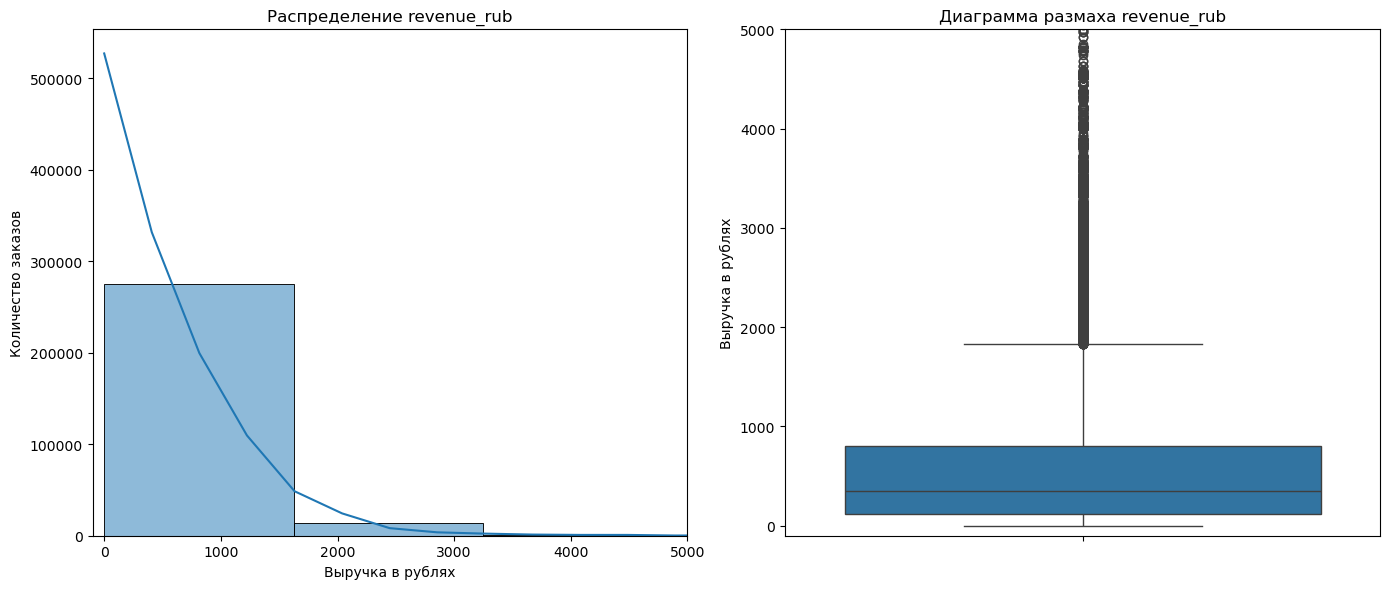


99-й перцентиль revenue_rub: 2628.42
Количество строк до фильтрации по 99-му перцентилю revenue_rub: 290230
Количество строк после фильтрации по 99-му перцентилю revenue_rub: 287405
Удалено строк: 2825 (0.97%)

--- Статистика по revenue_rub после фильтрации 99 перцентиля ---
count    287405.000000
mean        518.719299
std         511.951843
min           0.000000
25%         112.599998
50%         344.829987
75%         788.900024
max        2628.421631
Name: revenue_rub, dtype: float64


In [40]:
print("\n--- Статистика по revenue_rub ---")
print(df_processed['revenue_rub'].describe())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_processed['revenue_rub'], bins=50, kde=True)
plt.title('Распределение revenue_rub')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество заказов')
plt.xlim(-100, 5000) # Ограничим ось X для лучшей видимости основного распределения

plt.subplot(1, 2, 2)
sns.boxplot(y=df_processed['revenue_rub'])
plt.title('Диаграмма размаха revenue_rub')
plt.ylabel('Выручка в рублях')
plt.ylim(-100, 5000) # Ограничим ось Y для лучшей видимости основного распределения

plt.tight_layout()
plt.show()

# Отфильтруем значения по 99 перцентилю
p99_revenue_rub = df_processed['revenue_rub'].quantile(0.99)
print(f"\n99-й перцентиль revenue_rub: {p99_revenue_rub:.2f}")

initial_rows = len(df_processed)
df_processed = df_processed[df_processed['revenue_rub'] <= p99_revenue_rub]
filtered_rows = len(df_processed)

print(f"Количество строк до фильтрации по 99-му перцентилю revenue_rub: {initial_rows}")
print(f"Количество строк после фильтрации по 99-му перцентилю revenue_rub: {filtered_rows}")
print(f"Удалено строк: {initial_rows - filtered_rows} ({((initial_rows - filtered_rows) / initial_rows) * 100:.2f}%)")

# Повторный describe для отфильтрованных данных
print("\n--- Статистика по revenue_rub после фильтрации 99 перцентиля ---")
print(df_processed['revenue_rub'].describe())


### Вывод по предобработке данных:

Проведена комплексная предобработка датасета за период с июня по октябрь 2024 года с целью подготовки данных для модели прогнозирования возврата пользователей.

1. Очистка от отрицательной выручки:
   - Удалены все заказы с отрицательной выручкой (revenue_rub).
   - Отрицательные значения (чаще всего — возвраты или отмены) искажают реальную картину финансовых транзакций пользователя и могут негативно сказаться на точности модели прогнозирования лояльности.
- Результат:
  - Из исходных 290 611 строк было удалено 381 (0.13%) записей.
  - Новый датасет (df_processed) содержит 290 230 строк.
  - Минимальное значение revenue_rub теперь равно 0.00, что корректно отражает неотрицательные финансовые операции.

2. Фильтрация выбросов по 99-му перцентилю revenue_rub:
   - Что сделано: Из датасета (df_processed) были удалены заказы, где revenue_rub превышает 99-й перцентиль (значение 2628.42 руб.).
   - Для построения точной модели прогнозирования возврата важно снизить влияние экстремальных значений (единичных сверхдорогих заказов), которые могут искажать средние показатели и не являются типичным поведением большинства пользователей.
- Результат:
  - Удалено 2825 строк (0.97% от уже очищенных данных, или 0.97% от 290230 строк).
  - Финальный датасет (df_processed после этого шага) содержит 287 405 строк.
  - Средняя выручка (mean) снизилась с 556.30 до 518.72 руб.
  - Стандартное отклонение (std) значительно уменьшилось с 875.82 до 511.95 руб., что свидетельствует о более однородном распределении данных.
  - Максимальное значение revenue_rub теперь составляет 2628.42 руб., что является более репрезентативным верхним порогом для большинства заказов.

Общие выводы:

- Проведенная очистка (удаление отрицательной выручки и фильтрация выбросов по 99-му перцентилю) сделала данные более качественными и пригодными для дальнейшего анализа.
- Датасет стал более «чистым» от аномалий, что является критически важным для создания надежной модели прогнозирования возврата пользователей.
- В финальном датасете представлены заказы с неотрицательной выручкой, где большинство операций находятся в пределах разумных значений, что позволит корректно рассчитать агрегированные признаки (LTV, средний чек и т.д.) для каждого пользователя.

# 4. Создание профиля пользователя

In [41]:
# Обязательная сортировка перед агрегацией
df_processed = df_processed.sort_values(by=['user_id', 'order_ts'])

# Создаем профиль пользователя
user_profiles = df_processed.groupby('user_id').agg(
    # Даты первого и последнего заказов
    first_order_dt=('order_ts', 'min'),
    last_order_dt=('order_ts', 'max'),
    
    # Характеристики первого заказа (берем первое встретившееся значение после сортировки)
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_genre=('event_type_main', 'first'),
    
    # Количественные показатели
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    
    # Среднее время между заказами (используем существующий days_since_prev)
    avg_time_between_orders=('days_since_prev', 'mean')
).reset_index()

# Проверка результата
print(user_profiles.head())
print(user_profiles.info())

           user_id      first_order_dt       last_order_dt first_device  \
0  0002849b70a3ce2 2024-08-20 16:08:03 2024-08-20 16:08:03       mobile   
1  0005ca5e93f2cf4 2024-07-23 18:36:24 2024-10-06 13:56:02       mobile   
2  000898990054619 2024-07-13 19:40:48 2024-10-23 15:12:00       mobile   
3  00096d1f542ab2b 2024-08-15 16:48:48 2024-08-15 16:48:48      desktop   
4  000a55a418c128c 2024-09-29 19:39:12 2024-10-15 10:29:04       mobile   

           first_region  first_partner first_genre  total_orders  \
0    Каменевский регион   Край билетов       театр             1   
1    Каменевский регион      Мой билет    выставки             2   
2  Североярская область    Лови билет!      другое             3   
3    Каменевский регион   Край билетов       театр             1   
4      Поленовский край  Лучшие билеты       театр             2   

   avg_revenue_rub  avg_tickets_count  avg_time_between_orders  
0      1521.939941           4.000000                      NaN  
1       77

### Добавим два бинарных признака
- is_two — совершил ли пользователь 2 и более заказа;
- is_five — совершил ли пользователь 5 и более заказов.

In [42]:
# is_two
user_profiles['is_two'] = (user_profiles['total_orders'] >= 2).astype(int)

# is_five
user_profiles['is_five'] = (user_profiles['total_orders'] >= 5).astype(int)

# Проверка результата:
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21838 non-null  object        
 1   first_order_dt           21838 non-null  datetime64[ns]
 2   last_order_dt            21838 non-null  datetime64[ns]
 3   first_device             21838 non-null  category      
 4   first_region             21838 non-null  category      
 5   first_partner            21838 non-null  category      
 6   first_genre              21838 non-null  category      
 7   total_orders             21838 non-null  int64         
 8   avg_revenue_rub          21838 non-null  float32       
 9   avg_tickets_count        21838 non-null  float64       
 10  avg_time_between_orders  13504 non-null  float32       
 11  is_two                   21838 non-null  int64         
 12  is_five                  21838 n

### Преобразуем типы данных для оптимизации памяти и улучшения производительности.

In [43]:
# Для total_orders
max_total_orders = user_profiles['total_orders'].max()
if max_total_orders < 32767:
    user_profiles['total_orders'] = user_profiles['total_orders'].astype('int16')
elif max_total_orders < 2_147_483_647:
    user_profiles['total_orders'] = user_profiles['total_orders'].astype('int32')

# Для avg_tickets_count
user_profiles['avg_tickets_count'] = user_profiles['avg_tickets_count'].astype('float32')

# Для is_two и is_five
user_profiles['is_two'] = user_profiles['is_two'].astype('int8')
user_profiles['is_five'] = user_profiles['is_five'].astype('int8')

# Проверим после преобразований
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21838 non-null  object        
 1   first_order_dt           21838 non-null  datetime64[ns]
 2   last_order_dt            21838 non-null  datetime64[ns]
 3   first_device             21838 non-null  category      
 4   first_region             21838 non-null  category      
 5   first_partner            21838 non-null  category      
 6   first_genre              21838 non-null  category      
 7   total_orders             21838 non-null  int16         
 8   avg_revenue_rub          21838 non-null  float32       
 9   avg_tickets_count        21838 non-null  float32       
 10  avg_time_between_orders  13504 non-null  float32       
 11  is_two                   21838 non-null  int8          
 12  is_five                  21838 n

### Используя данные о профилях пользователей, рассчитаем:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

In [44]:
# Общее число пользователей в выборке
total_users = user_profiles.shape[0]

# Средняя выручка с одного заказа
total_revenue_all_users = (user_profiles['avg_revenue_rub'] * user_profiles['total_orders']).sum()
total_orders_all_users = user_profiles['total_orders'].sum()
average_revenue_per_order = total_revenue_all_users / total_orders_all_users

# Доля пользователей, совершивших 2 и более заказа
share_two_or_more_orders = user_profiles['is_two'].mean()

# Доля пользователей, совершивших 5 и более заказов
share_five_or_more_orders = user_profiles['is_five'].mean()

print(f"1. Общее число пользователей в выборке: {total_users}")
print(f"2. Средняя выручка с одного заказа: {average_revenue_per_order:.2f} RUB")
print(f"3. Доля пользователей, совершивших 2 и более заказа: {share_two_or_more_orders:.2%}")
print(f"4. Доля пользователей, совершивших 5 и более заказов: {share_five_or_more_orders:.2%}")

1. Общее число пользователей в выборке: 21838
2. Средняя выручка с одного заказа: 518.72 RUB
3. Доля пользователей, совершивших 2 и более заказа: 61.70%
4. Доля пользователей, совершивших 5 и более заказов: 29.00%


### Изучим статистические показатели:

In [45]:
# По общему числу заказов (total_orders)
print("\n1. Статистика по 'total_orders' (общее число заказов на пользователя):")
total_orders_stats = user_profiles['total_orders'].describe()
print(total_orders_stats)
print(f"Асимметрия (Skewness): {user_profiles['total_orders'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['total_orders'].kurt():.2f}")


1. Статистика по 'total_orders' (общее число заказов на пользователя):
count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64
Асимметрия (Skewness): 41.49
Эксцесс (Kurtosis): 2623.48


In [46]:
# По среднему числу билетов в заказе (avg_tickets_count)
print("\n2. Статистика по 'avg_tickets_count' (среднее число билетов в заказе на пользователя):")
avg_tickets_stats = user_profiles['avg_tickets_count'].describe()
print(avg_tickets_stats)
print(f"Асимметрия (Skewness): {user_profiles['avg_tickets_count'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['avg_tickets_count'].kurt():.2f}")


2. Статистика по 'avg_tickets_count' (среднее число билетов в заказе на пользователя):
count    21838.000000
mean         2.744062
std          0.913077
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_count, dtype: float64
Асимметрия (Skewness): 0.56
Эксцесс (Kurtosis): 1.59


In [47]:
# По среднему количеству дней между покупками (avg_time_between_orders)
print("\n3. Статистика по 'avg_time_between_orders' (среднее количество дней между покупками):")
# Важно: этот столбец содержит NaN для пользователей с одним заказом.
# describe() автоматически игнорирует NaN, поэтому 'count' будет меньше общего числа пользователей.
avg_time_stats = user_profiles['avg_time_between_orders'].describe()
print(avg_time_stats)
print(f"Асимметрия (Skewness): {user_profiles['avg_time_between_orders'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['avg_time_between_orders'].kurt():.2f}")


3. Статистика по 'avg_time_between_orders' (среднее количество дней между покупками):
count    13504.000000
mean        15.864347
std         22.330114
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_time_between_orders, dtype: float64
Асимметрия (Skewness): 2.57
Эксцесс (Kurtosis): 7.88


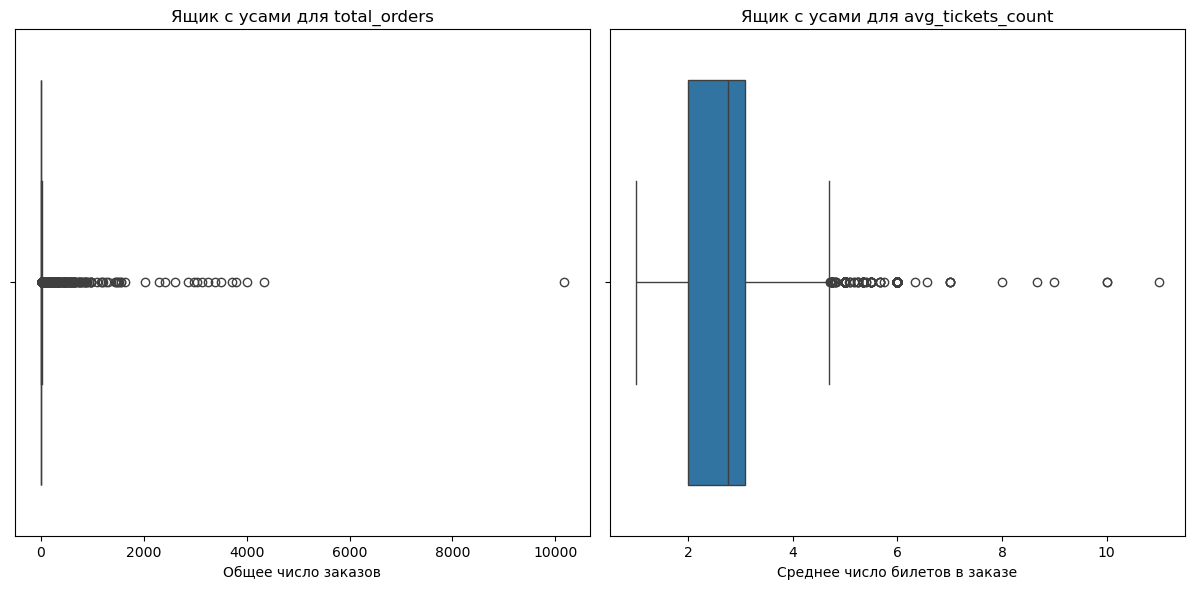

In [48]:
# Настройка графиков
plt.figure(figsize=(18, 6))

# Ящик с усами для total_orders
plt.subplot(1, 3, 1)
sns.boxplot(x=user_profiles['total_orders'])
plt.title("Ящик с усами для total_orders")
plt.xlabel("Общее число заказов")

# Ящик с усами для avg_tickets_count
plt.subplot(1, 3, 2)
sns.boxplot(x=user_profiles['avg_tickets_count'])
plt.title("Ящик с усами для avg_tickets_count")
plt.xlabel("Среднее число билетов в заказе")

# Отображение графиков
plt.tight_layout()
plt.show()

**Оценка объема данных:**

- Общее число пользователей (21838): Это хороший объем для проведения статистического анализа. Достаточно, чтобы выявлять тенденции и паттерны.
- Высокая доля повторных заказов:
  - 61.7% пользователей совершили 2 и более заказа.
  - 29% пользователей совершили 5 и более заказов.
  Это указывает на очень хорошую лояльность или высокую вовлеченность пользователей.
- Средняя выручка с одного заказа (518.72 RUB).

**Анализ аномалий и статистических показателей:**

- Показатель total_orders (Общее число заказов)
    - Аномалия: Максимальное значение — 10 168 заказов. При этом медиана — всего 2 заказа, а 75-й перцентиль — 5 заказов.
Это критическая аномалия. Среднее значение (13.16) в 6 раз больше медианы только из-за сверхтяжелого "хвоста". Коэффициент асимметрии (41.49) и эксцесс (2623.48) подтверждают, что распределение максимально далеко от нормального.

- Показатель avg_tickets_count (Среднее число билетов)
   - Аномалия: Максимальное значение — 11.
Это не аномалия. 11 билетов в заказе — это реальная ситуация (большая компания, школьная группа и т.д.). Коэффициент асимметрии (0.56) низкий, распределение выглядит здоровым.

- Показатель avg_time_between_orders (Время между покупками)
   - Статистика: В расчете участвовало 13 504 человек
   - Аномалия: Минимальное значение 0 дней (пользователь делает несколько заказов в один день) и максимальное 148 дней. Среднее (15.86) и медиана (8.0).
Данные выглядят логично. Коэффициент асимметрии (2.57) умеренный.



### Проверим 95-й и 99-й процентиль столбца total_orders

In [49]:
# Вычисление 95-го и 99-го процентилей
percentile_95 = user_profiles['total_orders'].quantile(0.95)
percentile_99 = user_profiles['total_orders'].quantile(0.99)

print("95-й процентиль total_orders:", percentile_95)
print("99-й процентиль total_orders:", percentile_99)


95-й процентиль total_orders: 31.0
99-й процентиль total_orders: 152.0


### Отфильтруем данные по 99-ому перцентилю

In [50]:
# Отфильтруем значения по 99 перцентилю
initial_rows = len(user_profiles)
user_profiles = user_profiles[user_profiles['total_orders'] <= percentile_99]
filtered_rows = len(user_profiles)

print(f"Количество строк до фильтрации по 99-му перцентилю total_orders: {initial_rows}")
print(f"Количество строк после фильтрации по 99-му перцентилю total_orders: {filtered_rows}")
print(f"Удалено строк: {initial_rows - filtered_rows} ({((initial_rows - filtered_rows) / initial_rows) * 100:.2f}%)")

Количество строк до фильтрации по 99-му перцентилю total_orders: 21838
Количество строк после фильтрации по 99-му перцентилю total_orders: 21622
Удалено строк: 216 (0.99%)


In [51]:
print("Статистика по 'total_orders' (после фильтрации):")
total_orders_stats = user_profiles['total_orders'].describe()
print(total_orders_stats)
print(f"Асимметрия (Skewness): {user_profiles['total_orders'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['total_orders'].kurt():.2f}")

Статистика по 'total_orders' (после фильтрации):
count    21622.000000
mean         6.496624
std         14.310784
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64
Асимметрия (Skewness): 5.42
Эксцесс (Kurtosis): 36.09


**Что было сделано:**

1. Идентификация аномалии: Изначально мы обнаружили, что в данных о total_orders присутствует экстремально большое значение (10 168 заказов), которое находится далеко за пределами распределения основной массы пользователей. Это было очевидно по следующим признакам:
  - Максимальное значение (10 168) было в сотни раз больше медианы (2).
  - Очень высокое стандартное отклонение (121.58), многократно превышающее среднее (13.16).
  - Экстремально высокие показатели асимметрии (41.49) и эксцесса (2623.48), указывающие на сильное искажение распределения выбросом.
  - Визуально на графике Boxplot (ящик с усами) большинство данных сосредоточено у нуля, а выброс представлял собой одну далекую точку.

2. Принятие решения о фильтрации: Было принято решение отфильтровать данные для того, чтобы получить более репрезентативные статистические показатели, которые отражают поведение большинства пользователей, а не искажены отдельными экстремальными значениями.

3. Выбор порога фильтрации: Были рассмотрены два варианта:
  - 95-й перцентиль (31 заказ): Этот порог отсекает 5% самых активных пользователей, что может привести к потере данных о клиентах, которые приносят значительную часть дохода.
  - 99-й перцентиль (152 заказа): Этот порог отсекает только 1% самых активных пользователей. Это позволило избавиться от явного технического мусора или единичных случаев оптовых закупок/ботов, сохраняя при этом ценный сегмент пользователей с высоким, но реальным числом заказов.

4. Окончательный выбор фильтрации: Фильтрация была проведена по 99-му перцентилю. Это было обосновано тем, что:
  - Минимальная потеря данных: Удаляется лишь 1% пользователей, что позволяет сохранить большую часть выборки.
  - Устранение явных искажений: Устраняется самое экстремальное значение (10 168), которое искажало среднее и другие статистические показатели.
  - Сохранение «Power Users»: Сегмент пользователей с количеством заказов от 32 до 152 (95-й и 99-й перцентили) был оставлен, поскольку это могут быть реальные, очень лояльные клиенты, которые важны для бизнеса.

**Результат фильтрации:**

- Количество пользователей: Сократилось с 21 838 до 21 622 (удалено 216 пользователей, 0.99%).
- Среднее число заказов (total_orders): Резко снизилось с 13.16 до 6.50.
- Стандартное отклонение: Значительно уменьшилось со 121.58 до 14.31, указывая на гораздо меньший разброс данных.
- Максимальное значение: Уменьшилось с 10 168 до 152.
- Асимметрия и эксцесс: Значительно снизились (с 41.49 до 5.42 и с 2623.48 до 36.09 соответственно), что делает распределение более адекватным для статистического анализа.

Вывод: Фильтрация по 99-му перцентилю позволила получить более реалистичные и репрезентативные статистические показатели по total_orders, которые лучше отражают поведение основной массы пользователей, сохранив при этом ценную информацию о самых лояльных клиентах.

# 5. Исследовательский анализ данных

##  Изучим распределение пользователей по признакам.

In [52]:
# Список признаков для анализа
features = ['first_genre', 'first_device', 'first_region', 'first_partner']

# Словарь для хранения результатов
results = {}

for feature in features:
    # Группируем, считаем количество пользователей
    dist = user_profiles.groupby(feature, observed=False).agg(
        user_count=('user_id', 'count')
    ).reset_index()
    
    # Считаем процент пользователей в каждом сегменте
    total_users = user_profiles['user_id'].nunique()  # Общее количество уникальных пользователей
    dist['proportion'] = (dist['user_count'] / total_users * 100).round(2)

    # Сохраняем в словарь
    results[feature] = dist
   
    # Сортируем по убыванию для наглядности
    dist = dist.sort_values(by='user_count', ascending=False)

    # Выводим результаты
    print(f'\nРаспределение пользователей по признаку: {feature}')
    print(dist)


Распределение пользователей по признаку: first_genre
  first_genre  user_count  proportion
2    концерты        9564       44.23
1      другое        5401       24.98
5       театр        4245       19.63
4     стендап        1110        5.13
3       спорт         794        3.67
0    выставки         413        1.91
6        ёлки          95        0.44

Распределение пользователей по признаку: first_device
  first_device  user_count  proportion
1       mobile       17906       82.81
0      desktop        3716       17.19

Распределение пользователей по признаку: first_region
                first_region  user_count  proportion
23        Каменевский регион        7086       32.77
60      Североярская область        3768       17.43
77       Широковская область        1223        5.66
45          Озернинский край         675        3.12
41      Малиновоярский округ         526        2.43
..                       ...         ...         ...
17            Залесский край           2    

**Анализ результатов:**

1. По типу первого мероприятия (firstgenre):
   - Около 44% пользователей совершили первый заказ на концерты, что является самым популярным жанром.
   - Другие жанры, такие как «другое», «театр», и «стендап» привлекают значительно меньшее количество пользователей.
   - Сегменты, такие как «ёлки», имеют крайне низкое количество пользователей (менее 1%).

2. По устройству первого заказа (firstdevice):
   - Большинство пользователей (82.81%) сделали свой первый заказ с мобильных устройств, что указывает на растущее предпочтение мобильных платформ для покупок.
   - Доля пользователей, использующих десктопы, составляет лишь 17.19%.

3. По региону первого заказа (firstregion):
   - Наиболее значительными регионами являются Каменевский регион и Североярская область, составляющие примерно 50% пользователей.
   - Множество регионов имеют очень небольшое количество пользователей, что указывает на возможность сегментации рынка.

4. По билетам первого заказа (firstpartner):
   - Наиболее популярным билетовым оператором является «Билеты без проблем» с долей около 23.90%.
   - Остальные операторы, такие как «Мой билет» и «Лови билет!» также занимают заметные доли, но значительно ниже, чем лидер.
   - Существует множество небольших операторов с очень низким количеством пользователей, что может говорить о высокой конкуренции в этом сегменте.
   
Пользователи не распределены равномерно по сегментам. Наблюдаются выраженные «точки входа» — это, в первую очередь, концерты как тип мероприятия и мобильные устройства как платформа для покупок. Сегменты с наименьшим числом пользователей, такие как «ёлки» и малочисленные регионы или операторы, также подтверждают наличие ярко выраженной концентрации интересов пользователей на определенных категориях.

## Проанализируем возвраты пользователей:

In [53]:
# Список признаков для анализа
features = ['first_genre', 'first_device', 'first_region', 'first_partner']

# Словарь для хранения итогов
results = {}

print("--- Расчет долей возвратов для каждого сегмента ---")
for feature in features:
    # Группируем и считаем количество пользователей с повторными заказами
    dist = user_profiles.groupby(feature, observed=False).agg(
        user_count=('user_id', 'count'),
        repeat_count=('is_two', 'sum')  # Считаем количество пользователей с 2 и более заказами
    ).reset_index()

    # Вычисляем долю пользователей с повторными заказами
    dist['repeat_proportion'] = (dist['repeat_count'] / dist['user_count']*100).round(2)

    # Сортируем по доле возвратов для лучшей читаемости в таблицах и на графиках
    dist = dist.sort_values(by='repeat_proportion', ascending=False)

    # Сохраняем в результирующий словарь для дальнейшего анализа
    results[feature] = dist
    print(f"\nРезультаты для сегмента '{feature}':")
    print(dist.to_string(index=False)) # Используем to_string для полного вывода без индекса
    print("-" * 50)

# Среднее по всем пользователям
overall_repeat_rate = user_profiles['is_two'].mean()
print(f"\nОбщая доля пользователей, совершивших 2 и более заказа (возвраты): {overall_repeat_rate:.2%}\n")

--- Расчет долей возвратов для каждого сегмента ---

Результаты для сегмента 'first_genre':
first_genre  user_count  repeat_count  repeat_proportion
   выставки         413           265              64.16
      театр        4245          2693              63.44
   концерты        9564          5912              61.82
    стендап        1110           676              60.90
     другое        5401          3217              59.56
      спорт         794           443              55.79
       ёлки          95            53              55.79
--------------------------------------------------

Результаты для сегмента 'first_device':
first_device  user_count  repeat_count  repeat_proportion
     desktop        3716          2372              63.83
      mobile       17906         10887              60.80
--------------------------------------------------

Результаты для сегмента 'first_region':
             first_region  user_count  repeat_count  repeat_proportion
        Верхозёрский кр

**Визуализируем результат**

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_22668\7433200.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot_genre = sns.barplot(x='first_genre', y='repeat_proportion', data=genre_data_sorted, palette='viridis', ax=axes[0])
C:\Users\DiFF1\AppData\Local\Temp\ipykernel_22668\7433200.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot_device = sns.barplot(x='first_device', y='repeat_proportion', data=device_data_sorted, palette='magma', ax=axes[1])


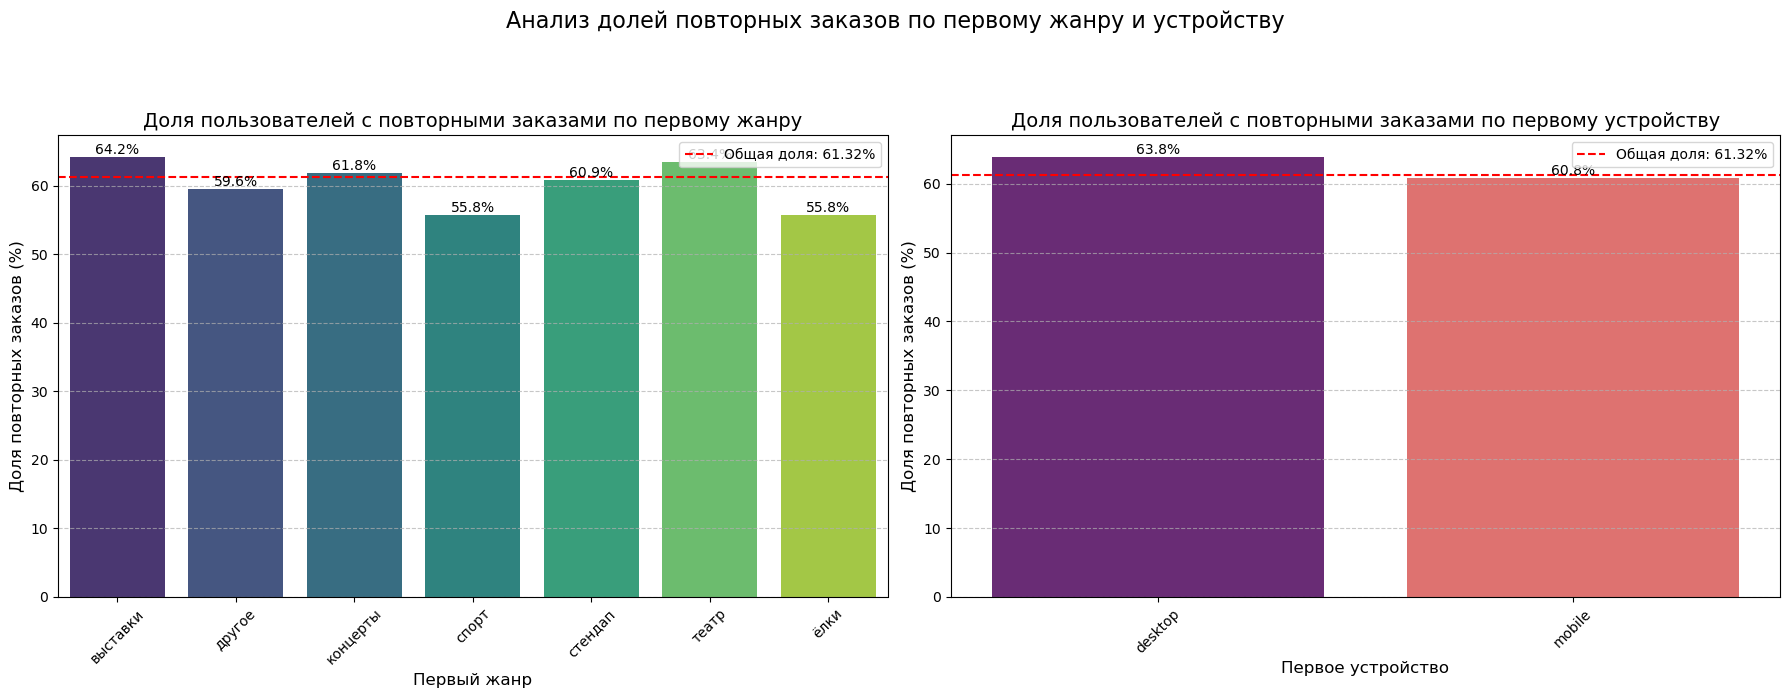

In [54]:
# Визуализация для сегментов first_genre и first_device

# Создаем одну фигуру с двумя подграфиками (1 строка, 2 столбца)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # Увеличиваем ширину для двух графиков

# --- График для first_genre ---
genre_data = results['first_genre']
# Сортируем данные по доле возвратов для более информативного графика
genre_data_sorted = genre_data.sort_values(by='repeat_proportion', ascending=False)
barplot_genre = sns.barplot(x='first_genre', y='repeat_proportion', data=genre_data_sorted, palette='viridis', ax=axes[0])

# Добавляем заголовок и подписи для первого подграфика
axes[0].set_title('Доля пользователей с повторными заказами по первому жанру', fontsize=14)
axes[0].set_xlabel('Первый жанр', fontsize=12)
axes[0].set_ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию общей доли
axes[0].axhline(y=overall_repeat_rate * 100, color='red', linestyle='--', label=f'Общая доля: {overall_repeat_rate:.2%}')
axes[0].legend()

axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений доли на график по первому жанру
for index, row in genre_data_sorted.iterrows():
    axes[0].text(index, row['repeat_proportion'], f'{row["repeat_proportion"] :.1f}%', 
                  color='black', ha='center', va='bottom')

# --- График для first_device ---
device_data = results['first_device']
# Сортируем данные по доле возвратов для более информативного графика
device_data_sorted = device_data.sort_values(by='repeat_proportion', ascending=False)
barplot_device = sns.barplot(x='first_device', y='repeat_proportion', data=device_data_sorted, palette='magma', ax=axes[1])

# Добавляем заголовок и подписи для второго подграфика
axes[1].set_title('Доля пользователей с повторными заказами по первому устройству', fontsize=14)
axes[1].set_xlabel('Первое устройство', fontsize=12)
axes[1].set_ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию общей доли
axes[1].axhline(y=overall_repeat_rate * 100, color='red', linestyle='--', label=f'Общая доля: {overall_repeat_rate:.2%}')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений доли на график по первому устройству
for index, row in device_data_sorted.iterrows():
    axes[1].text(index, row['repeat_proportion'], f'{row["repeat_proportion"] :.1f}%', 
                  color='black', ha='center', va='bottom')

# Общий заголовок для всей фигуры
plt.suptitle('Анализ долей повторных заказов по первому жанру и устройству', fontsize=16, y=1.02)

# Оптимизируем отступы, чтобы все элементы поместились, учитывая suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Показываем графики
plt.show()

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_22668\518433869.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


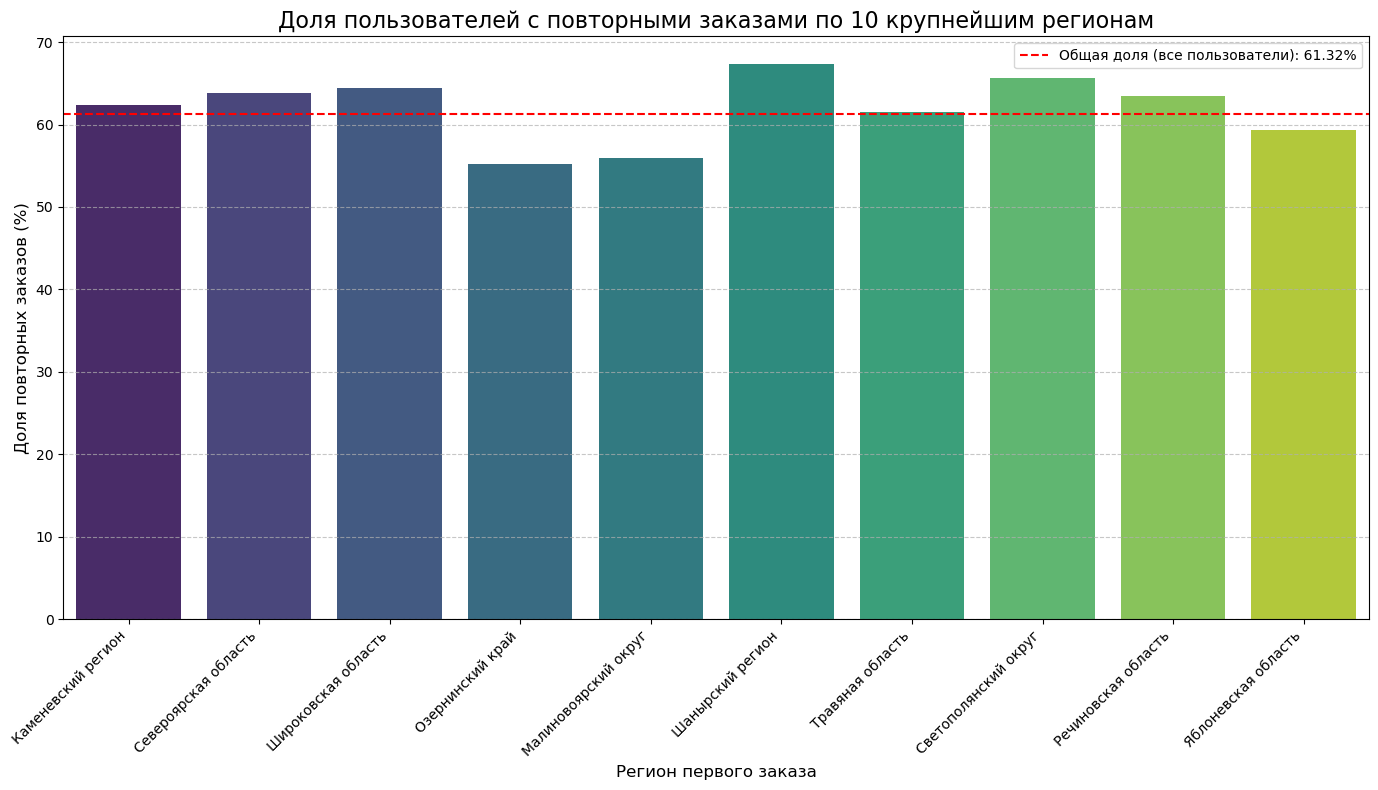

In [55]:
# Визуализация для сегмента first_region (топ-10 по user_count)

# Получаем данные для региона
region_data = results['first_region']
# Сортируем по user_count и выбираем топ-10
top_10_regions_by_users = region_data.sort_values(by='user_count', ascending=False).head(10)

# Настраиваем график
plt.figure(figsize=(14, 8)) # Увеличиваем размер для лучшей читаемости
sns.barplot(
    x='first_region',
    y='repeat_proportion',
    data=top_10_regions_by_users,
    palette='viridis',
    order=top_10_regions_by_users['first_region'].tolist() # Явно указываем порядок и список категорий
)

# Добавляем заголовок и подписи осей
plt.title('Доля пользователей с повторными заказами по 10 крупнейшим регионам', fontsize=16)
plt.xlabel('Регион первого заказа', fontsize=12)
plt.ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию, показывающую общую долю возвратов
# Умножаем overall_repeat_rate на 100, чтобы он был в той же шкале, что и repeat_proportion
plt.axhline(y=overall_repeat_rate * 100, color='red', linestyle='--', label=f'Общая доля (все пользователи): {overall_repeat_rate:.2%}')
plt.legend()

# Улучшаем читаемость меток по оси X
plt.xticks(rotation=45, ha='right') # Поворачиваем метки, чтобы они не накладывались

# Добавляем сетку для лучшей ориентации
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Оптимизируем отступы, чтобы все элементы поместились
plt.tight_layout()

# Показываем график
plt.show()

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_22668\3786843732.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


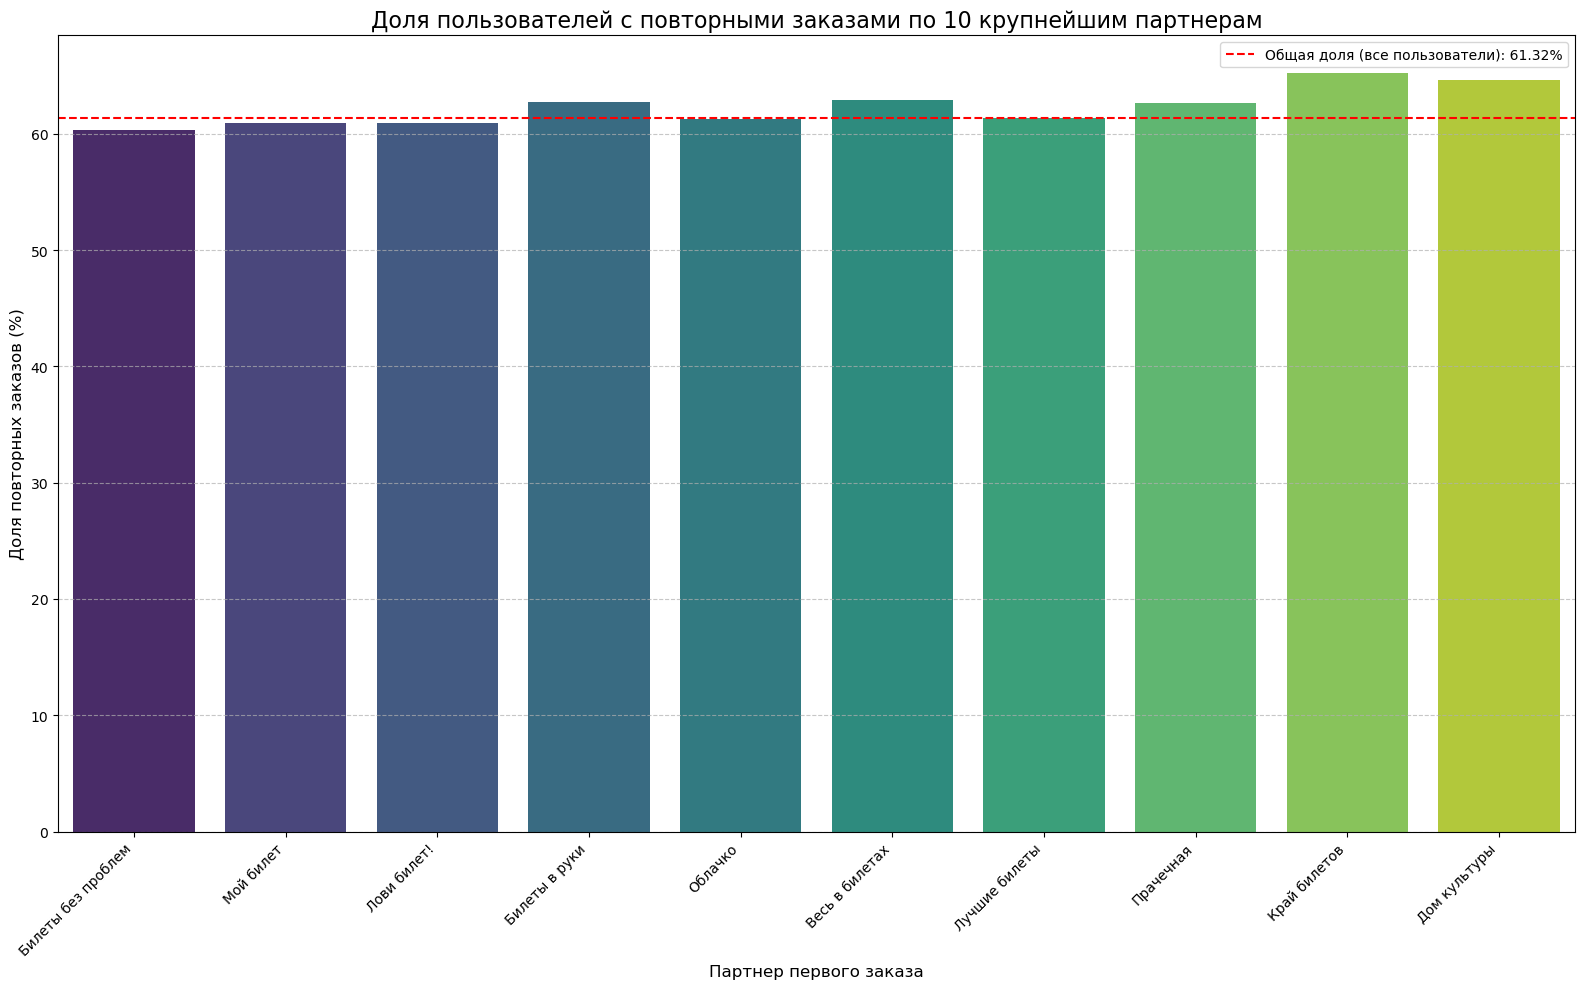

In [56]:
# Получаем данные для партнеров
partner_data = results['first_partner']
# Сортируем по user_count и выбираем топ-10
top_10_partners_by_users = partner_data.sort_values(by='user_count', ascending=False).head(10)

# Настраиваем график
plt.figure(figsize=(16, 10))  # Увеличиваем размеры для лучшей читаемости
barplot = sns.barplot(
    x='first_partner',
    y='repeat_proportion',
    data=top_10_partners_by_users,
    palette='viridis',
    order=top_10_partners_by_users['first_partner'].tolist()  # Явно указываем порядок и список категорий
)

# Добавляем заголовок и подписи осей
plt.title('Доля пользователей с повторными заказами по 10 крупнейшим партнерам', fontsize=16)
plt.xlabel('Партнер первого заказа', fontsize=12)
plt.ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию, показывающую общую долю возвратов
plt.axhline(y=overall_repeat_rate * 100, color='red', linestyle='--',
            label=f'Общая доля (все пользователи): {overall_repeat_rate:.2%}')
plt.legend()

# Улучшаем читаемость меток по оси X
plt.xticks(rotation=45, ha='right')

# Добавляем сетку для лучшей ориентации
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Настраиваем отступы
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.9)

# Показываем график
plt.tight_layout()
plt.show()

Средняя доля повторных заказов по всей выборке составляет примерно 61.32%.

### Общие выводы по всем сегментам:

**Сегменты пользователей, чаще возвращающихся на Яндекс Афишу:**

По первому жанру:

- Выставки: 413 пользователей (64.16%)
- Театр: 4245 пользователей (63.44%)
- Концерты: 9564 пользователя (61.82%)

По первому устройству:

- Desktop: 3716 пользователей (63.83%)
- Mobile: 17906 пользователей (60.80%)

По первому региону:

- Шанырский регион: 502 пользователя (67.33%)
- Горицветская область: 247 пользователей (66.80%)
- Светополянский округ: 457 пользователей (65.65%)
- Широковская область: 1223 пользователя (64.43%)
- Североярская область: 3768 пользователей (63.83%)
- Потенциальные лидеры (с меньшей выборкой):
  - Озернопольская область: 29 пользователей (89.66%)
  - Радужнопольский край: 24 пользователя (79.17%)
  - Лесостепной край: 60 пользователей (71.67%)

По первому партнеру:

- «Край билетов»: 454 пользователя (65.20%)
- «Дом культуры»: 356 пользователей (64.61%)
- «Весь в билетах»: 1286 пользователей (62.91%)
- «Билеты в руки»: 2557 пользователей (62.77%)
- Потенциальные лидеры (с меньшей выборкой):
  - «Быстрый кассир»: 61 пользователь (85.25%)
  - «Реестр»: 33 пользователя (81.82%)


**Ключевые успешные точки входа:**

1. Театральные события (4 245 чел., 63.44%): Несмотря на то, что Выставки (413 чел., 64.16%) показывают ещё более высокий процент повторных заказов при меньшем объёме, театр остаётся одной из наиболее надёжных точек входа благодаря сочетанию достаточно большого объёма привлечённых пользователей и высокой лояльности.

2. Десктопная версия сайта (3 716 чел., 63.83%): Несмотря на то, что мобильные устройства доминируют по общему объёму пользователей (17 906 чел.), именно десктопная версия сайта конвертирует новых пользователей в постоянных с более высокой эффективностью. Это может указывать на специфику поведения пользователей, использующих десктоп для более вдумчивых покупок или планирования.

3. Региональные центры с высокой долей возврата:

  - Шанырский регион (502 чел., 67.33%) и Горицветская область (247 чел., 66.80%) демонстрируют наивысший процент повторных заказов, что делает их особо перспективными для дальнейшего изучения и потенциального масштабирования, несмотря на меньший объём по сравнению с Североярской областью.
  - Североярская область (3 768 чел., 63.83%) также является важной точкой роста благодаря большому объёму пользователей, проявляющих повышенную склонность к повторным покупкам.

4. Партнёрские каналы с высокой долей лояльности:

  - «Край билетов» (454 чел., 65.20%) и «Дом культуры» (356 чел., 64.61%) являются наиболее эффективными с точки зрения конвертации в повторные заказы.
  - «Билеты в руки» (2 557 чел., 62.77%) обеспечивает наиболее стабильный приток пользователей, готовых к совершению последующих покупок, что делает его ценным каналом с точки зрения объёма.

5. Перспективные нишевые точки (высокий потенциал при малом объёме):

  - Партнёр «Быстрый кассир» (61 чел., 85.25%) и «Реестр» (33 чел., 81.82%) демонстрируют аномально высокий уровень возврата, что указывает на исключительное качество привлечённых ими пользователей.
  - Лесостепной край (60 чел., 71.67%) также выделяется высокой долей лояльности.
  
Фокусировка на увеличении охвата в этих сегментах, а также детальное изучение причин их высокой эффективности, может стать ключевым фактором для дальнейшего роста показателей удержания Яндекс Афиши.

### Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

**Гипотеза 1:**
Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

В ходе анализа данных установлено, что пользователи, приобретающие билеты на культурные мероприятия (выставки, театр), демонстрируют значительно более высокую степень возврата, составившую около 64%. Напротив, пользователи спортивных мероприятий имеют самую низкую пропорцию возвратов — примерно 55.79%. Таким образом, вопреки исходной гипотезе, оказывается, что пользователи культурных мероприятий возвращаются на платформу значительно чаще.

Результат: Гипотеза №1 НЕ ПОДТВЕРДИЛАСЬ.

**Гипотеза 2:**
В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Анализ данных показал, что наиболее активными пользователями являются жители менее населенных регионов с высоким уровнем повторных заказов. Например, Озернопольская область с 29 пользователями имеет 89.66% долю повторных заказов, Радужнопольский край, где всего 24 пользователя и 79.17% доля повторных заказов. Напротив, регионы с большим количеством пользователей, такие как Каменноозерный край (675 пользователей), демонстрируют более низкие значения повторных заказов — 55.26%. Также крупные регионы, такие как Североярская область (3768 пользователей), показывают продолжение этой тенденции — 63.83% доля повторных заказов.

Таким образом, высокая активность пользователей не всегда коррелирует с высокой долей повторных заказов; наоборот, в регионах с большим числом пользователей наблюдается более низкий уровень повторных заказов.


Результат: Гипотеза №2 ПОДТВЕРДИЛАСЬ ОБРАТНОЙ ЗАВИСИМОСТЬЮ: в регионах с большим количеством пользователей доля повторных заказов оказывается ниже, чем в менее активных регионах.

## Проведем исследование поведения пользователей через показатели выручки и состава заказа

### Рассчитываем общие метрики

In [57]:
# Средняя выручка с заказа
average_revenue = user_profiles['avg_revenue_rub'].mean()
print(f'Средняя выручка с заказа: {average_revenue:.2f} руб.')

# Среднее количество билетов на заказ
average_ticket_count = user_profiles['avg_tickets_count'].mean()
print(f'Среднее количество билетов на заказ: {average_ticket_count:.2f}')

Средняя выручка с заказа: 545.34 руб.
Среднее количество билетов на заказ: 2.74


### Построим сравнительные гистограммы распределения средней выручки с билета ( avg_revenue_rub )

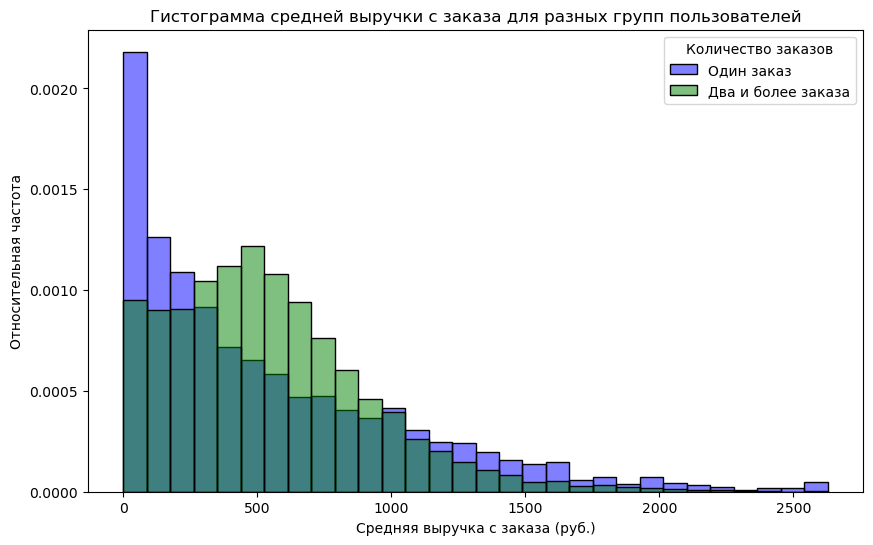

In [58]:
# Группа пользователей с единственным заказом
single_orders_users = user_profiles.query('total_orders == 1')['avg_revenue_rub']

# Группа пользователей с двумя и более заказами
repeat_customers = user_profiles.query('total_orders > 1')['avg_revenue_rub']

# Настройка внешнего вида графика
plt.figure(figsize=(10, 6))
sns.histplot(single_orders_users, kde=False, label='Один заказ', color='blue', bins=30, alpha=0.5, stat="density")
sns.histplot(repeat_customers, kde=False, label='Два и более заказа', color='green', bins=30, alpha=0.5, stat="density")

# Добавление легенды и подписей осей
plt.title("Гистограмма средней выручки с заказа для разных групп пользователей")
plt.xlabel("Средняя выручка с заказа (руб.)")
plt.ylabel("Относительная частота")
plt.legend(title="Количество заказов")

# Отображение графика
plt.show()

Анализируя гистограмму, можно ответить на следующие вопросы:

1. В каких диапазонах средней выручки концентрируются пользователи из каждой группы?

- Группа "Один заказ" (синие столбцы): Пользователи этой группы наиболее сильно концентрируются в диапазоне очень низкой средней выручки, преимущественно от 0 до ~300 рублей. Наблюдается очень высокий и резкий пик в самом первом интервале (предположительно от 0 до ~100-150 рублей).
- Группа "Два и более заказа" (зеленые столбцы, включая темное основание и светлую вершину): Пользователи этой группы концентрируются в более высоком диапазоне средней выручки. Их пик смещен вправо и приходится примерно на диапазон от ~400 до ~600 рублей. Общая концентрация для этой группы находится преимущественно в диапазоне от ~300 до ~900 рублей.

2. Есть ли различия между группами?

Да, различия между группами существенны:

- Расположение пиков концентрации: Для пользователей с одним заказом пик находится в самом начале шкалы (очень низкие значения выручки), тогда как для пользователей с двумя и более заказами пик значительно смещен вправо, в область средних значений выручки.
- Форма распределения:
   - Распределение для группы "Один заказ" крайне скошено вправо с очень резким спадом после начального пика. Это означает, что подавляющее большинство пользователей, сделавших только один заказ, имели очень низкую среднюю выручку с этого заказа.
   - Распределение для группы "Два и более заказа" также скошено вправо, но менее резко. Оно более широкое и сглаженное, смещено к более высоким значениям выручки и охватывает более широкий диапазон значений с заметной частотой.
- Доминирование в диапазонах:
   - Группа "Один заказ" значительно преобладает в диапазоне средней выручки от 0 до ~300 рублей.
   - Группа "Два и более заказа" доминирует в диапазонах от ~300-400 рублей и выше, показывая, что пользователи, делающие несколько заказов, в среднем тратят больше за один заказ или имеют более широкий разброс трат, включая более крупные суммы.

## Сравним распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_22668\1672323021.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='user_group', y='avg_revenue_rub', data=combined_data, palette=['blue', 'green'])


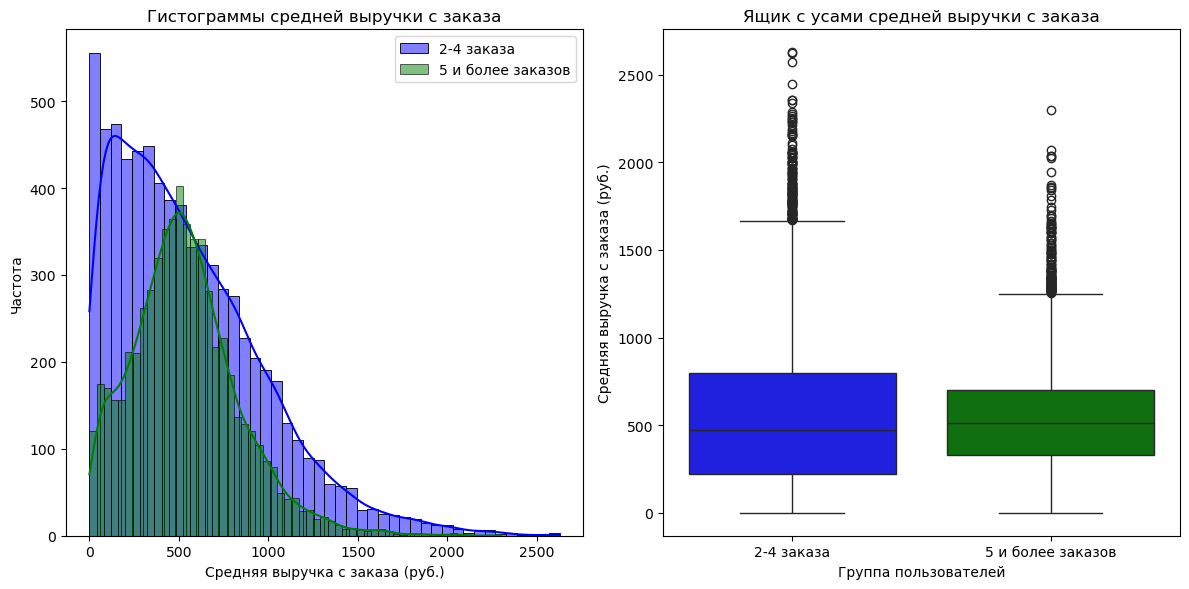

In [59]:
# Фильтрация данных
group_2_4 = user_profiles[(user_profiles['total_orders'] >= 2) & (user_profiles['total_orders'] <= 4)]
group_5_more = user_profiles[user_profiles['total_orders'] >= 5]

# Использование .loc[] для изменения данных
group_2_4 = group_2_4.copy()
group_2_4.loc[:, 'user_group'] = '2-4 заказа'

group_5_more = group_5_more.copy()
group_5_more.loc[:, 'user_group'] = '5 и более заказов'

# Объединяем данные для ящика с усами
combined_data = pd.concat([group_2_4[['avg_revenue_rub', 'user_group']], 
                            group_5_more[['avg_revenue_rub', 'user_group']]])

# Гистограммы
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(group_2_4['avg_revenue_rub'], kde=True, label='2-4 заказа', color='blue')
sns.histplot(group_5_more['avg_revenue_rub'], kde=True, label='5 и более заказов', color='green')
plt.title('Гистограммы средней выручки с заказа')
plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Частота')
plt.legend()

# Ящик с усами
plt.subplot(1, 2, 2)
sns.boxplot(x='user_group', y='avg_revenue_rub', data=combined_data, palette=['blue', 'green'])
plt.title('Ящик с усами средней выручки с заказа')
plt.xlabel('Группа пользователей')
plt.ylabel('Средняя выручка с заказа (руб.)')

plt.tight_layout()
plt.show()

### Сравнение распределений по средней выручке с заказа:

**1. Форма распределения (Гистограммы):**
  - Оба распределения сильно скошены вправо, что типично для данных о выручке/стоимости, где большинство значений находится на более низком конце, но есть длинный хвост более высоких значений.
  - Распределение для группы "2-4 заказа" (синий цвет) имеет более выраженный пик на более низких значениях средней выручки (около 200-300 руб.).
  - Распределение для группы "5 и более заказов" (зеленый цвет) имеет более плоский и широкий пик, который смещен вправо (около 400-500 руб.), что указывает на то, что у этой группы большая доля пользователей имеет среднюю выручку с заказа в этом диапазоне.
  - Несмотря на смещение, наблюдается значительное перекрытие между двумя распределениями.

**2. Центральная тенденция и разброс (Ящик с усами):**
- Медиана (горизонтальная линия внутри ящика):
     - Для группы "2-4 заказа" медиана находится примерно на уровне 480-500 руб.
     - Для группы "5 и более заказов" медиана находится примерно на уровне 550-600 руб.
     - Таким образом, медианная средняя выручка с заказа у пользователей, совершивших 5 и более заказов, выше.
- Интерквартильный размах (IQR - высота ящика):
     - Для группы "2-4 заказа" ящик простирается примерно от 250 руб. до 780 руб. (IQR ≈ 530 руб.).
     - Для группы "5 и более заказов" ящик простирается примерно от 320 руб. до 700 руб. (IQR ≈ 380 руб.).
     - Это говорит о том, что центральные 50% значений средней выручки с заказа у пользователей, совершивших 5 и более заказов, имеют несколько меньший разброс и более концентрированы вокруг медианы.
- Усы (Whisker):
     - Усы для "2-4 заказа" простираются немного шире в верхнюю сторону, чем для "5 и более заказов".
- Выбросы (точки за пределами усов):
     - Обе группы имеют значительное количество выбросов с высокой средней выручкой с заказа, что указывает на наличие пользователей с очень дорогими заказами. Выбросы в группе "2-4 заказа" достигают более высоких значений (до 2500 руб. и выше) по сравнению с группой "5 и более заказов" (до 2300 руб.).

Пользователи, совершившие 5 и более заказов, как правило, имеют более высокую среднюю выручку с заказа по сравнению с пользователями, совершившими 2–4 заказа. Это подтверждается следующими наблюдениями:

- Смещение распределения: Гистограмма для группы "5 и более заказов" смещена вправо, с пиком на более высоких значениях.
- Медиана: Медианное значение средней выручки с заказа для группы "5 и более заказов" выше (примерно 550-600 руб.) по сравнению с группой "2-4 заказа" (примерно 480-500 руб.).
- Положение ящика: Весь ящик для группы "5 и более заказов" находится выше, чем для группы "2-4 заказа", что означает, что большинство значений средней выручки с заказа в первой группе выше.

Хотя существуют индивидуальные случаи и значительное перекрытие, общая тенденция указывает на то, что более лояльные пользователи (с 5+ заказами) приносят больше выручки в среднем с каждого заказа.

## Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

### Изучим распределение пользователей по среднему количеству билетов в заказе ( avg_tickets_count )

--- Описательная статистика для avg_tickets_count ---
count    21622.000000
mean         2.744256
std          0.917467
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64


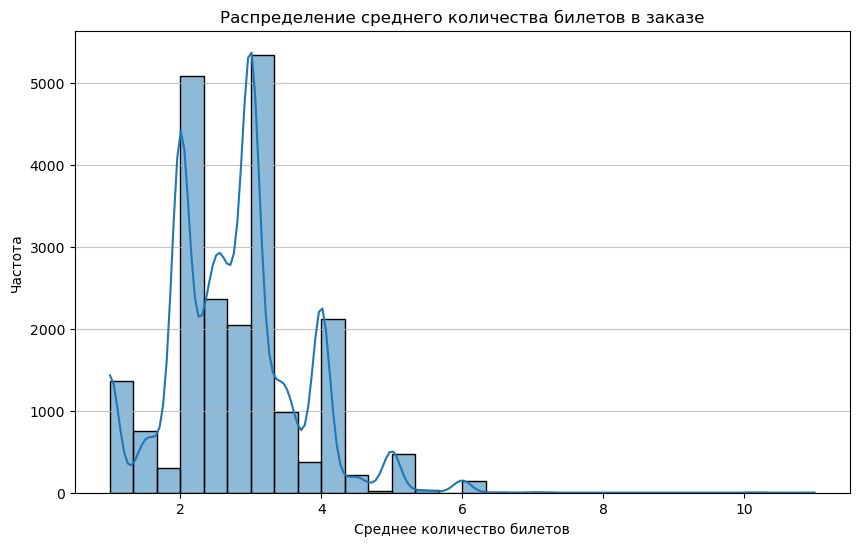

In [60]:
print("--- Описательная статистика для avg_tickets_count ---")
print(user_profiles['avg_tickets_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_profiles['avg_tickets_count'], bins=30, kde=True)
plt.title('Распределение среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Меры центральной тенденции:**
- Среднее (mean): 2.74 билета.
- Медиана (50%): 2.75 билета.
Среднее и медиана очень близки, что на первый взгляд может указывать на симметричное распределение. Однако гистограмма показывает, что это не так; их близость в данном случае скорее обусловлена симметричным расположением нескольких выраженных мод относительно центра, а не общей симметрией унимодального распределения.

**Меры разброса:**
- Стандартное отклонение (std): 0.917 билета. Это указывает на относительно умеренный разброс данных вокруг среднего, но большая часть дисперсии приходится на несколько основных пиков.
- Квартили:
   - 25% (Q1): 2.00 билета. Четверть пользователей в среднем заказывает 2 билета или меньше.
   - 75% (Q3): 3.10 билета. Три четверти пользователей в среднем заказывают 3.1 билета или меньше.
   - Межквартильный размах (IQR = Q3 - Q1): 3.10 - 2.00 = 1.10. Большая часть пользователей (центральные 50%) имеет среднее количество билетов от 2 до 3.1.

**Форма распределения (по гистограмме):**
- Мультимодальность: Распределение ярко выражено мультимодальным (многовершинным). Это ключевая особенность. Наблюдаются несколько отчетливых пиков:
  - Первый значительный пик: Около 2 билетов. Это очень распространенное значение, с частотой более 5000 пользователей.
  - Второй значительный пик: Около 3 билетов. Также очень распространенное значение, с частотой более 5000 пользователей, возможно, даже самый высокий пик.
  - Третий значительный пик: Около 4 билетов. С частотой около 2000-2200 пользователей.
  - Менее выраженные пики: Около 1 билета (более 1000 пользователей) и около 5 билетов (несколько сотен пользователей).
- Концентрация данных: Подавляющее большинство пользователей имеют среднее количество билетов от 1 до 4. Эти значения формируют основные "горбы" распределения.
- Хвосты распределения:
  - Правый хвост: Распределение имеет длинный правый хвост, что указывает на наличие небольшого числа пользователей, которые в среднем заказывают значительно больше билетов (до 11), хотя такие случаи редки. Частота резко падает после 4-5 билетов.
  - Левый хвост: Начинается от 1 билета и быстро поднимается к первому пику на 2 билетах.

**Основные выводы:**

- Пользователи склонны заказывать небольшое, целое количество билетов: Наибольшая концентрация пользователей наблюдается для средних значений 2, 3 и 4 билета, а также 1. Это может указывать на типичные сценарии использования: поход одному, вдвоем, втроем или вчетвером.
- Два основных "типа" пользователей по среднему числу билетов: Существуют две крупные группы пользователей, одна со средним числом билетов около 2, другая — около 3.
- Редкость больших заказов: Крайне мало пользователей, которые в среднем заказывают более 5-6 билетов. Максимальное значение в 11 билетов является редким исключением.

### Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе

Анализ пользовательских сегментов по среднему количеству билетов:
  avg_tickets_segment  total_users  repeat_buyer_percentage
0         1-2 tickets         6150                    40.11
1         2-3 tickets         9922                    74.26
2         3-5 tickets         5356                    62.75
3          5+ tickets          194                    32.47


C:\Users\DiFF1\AppData\Local\Temp\ipykernel_22668\3532078867.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = user_profiles.groupby('avg_tickets_segment').agg(


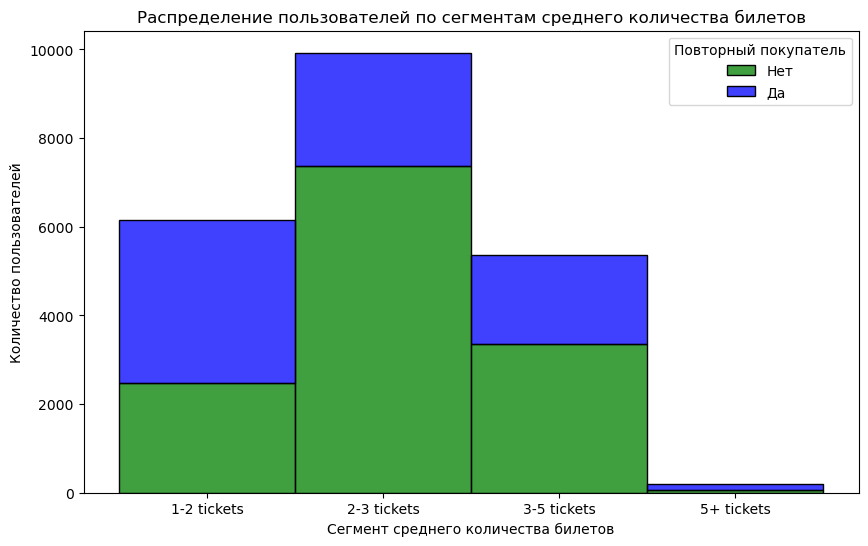

In [61]:
# Определяем границы интервалов (бины)
bins = [1, 2, 3, 5, np.inf]

# Определяем метки для каждого сегмента
labels = [
    '1-2 tickets',
    '2-3 tickets',
    '3-5 tickets',
    '5+ tickets'
]

# Создаем новую колонку 'avg_tickets_segment'
user_profiles['avg_tickets_segment'] = pd.cut(
    user_profiles['avg_tickets_count'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True # Включает нижнюю границу в первый интервал, т.е. [1, 2]
)

# Группируем по новому сегменту и считаем агрегированные метрики
segment_analysis = user_profiles.groupby('avg_tickets_segment').agg(
    total_users=('user_id', 'count'), # Общее число пользователей в сегменте
    # Доля повторных покупателей 
    repeat_buyer_proportion=('is_two', 'mean')
).reset_index() # Сбрасываем индекс, чтобы 'avg_tickets_segment' стал обычной колонкой

# Форматируем долю в проценты для лучшей читаемости
segment_analysis['repeat_buyer_percentage'] = (segment_analysis['repeat_buyer_proportion'] * 100).round(2)

# Выводим результаты
print("Анализ пользовательских сегментов по среднему количеству билетов:")
print(segment_analysis[[
    'avg_tickets_segment',
    'total_users',
    'repeat_buyer_percentage'
]].sort_values('avg_tickets_segment'))

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data=user_profiles, x='avg_tickets_segment', hue='is_two', multiple='stack', palette=['blue', 'green'])
plt.title('Распределение пользователей по сегментам среднего количества билетов')
plt.xlabel('Сегмент среднего количества билетов')
plt.ylabel('Количество пользователей')
plt.legend(title='Повторный покупатель', labels=['Нет', 'Да'])
plt.show()

**Распределение пользователей по сегментам неравномерное и сконцентрированное:**

- Сегмент "2-3 tickets" является самым крупным, охватывая 9922 пользователя, что составляет почти половину всех пользователей в данных (45.9%).
- Сегменты "1-2 tickets" (6150 пользователей) и "3-5 tickets" (5356 пользователей) также значительны, но меньше лидера.
- Сегмент "5+ tickets" является крайне малым, всего 194 пользователя, что составляет менее 1% от общей базы (0.9%).

Таким образом, большая часть пользователей сосредоточена в сегментах со средним количеством билетов от 1 до 5, с явным доминированием сегмента "2-3 tickets".

**Аномально высокая доля повторных покупок:**
- Сегмент "2-3 tickets" выделяется значительно высоким показателем в 74.26% повторных покупателей. Это значительно выше, чем в любом другом сегменте, что указывает на очень лояльную или удовлетворенную аудиторию, которая чаще всего покупает 2-3 билета.

**Аномально низкая доля повторных покупок:**
- Сегмент "5+ tickets" имеет самую низкую долю повторных покупок — всего 32.47%. Учитывая, что это сегмент с наибольшим средним количеством билетов, это довольно низкий показатель лояльности по сравнению с другими группами.
- Сегмент "1-2 tickets" также имеет относительно низкую долю повторных покупок (40.11%) по сравнению с сегментами, где пользователи покупают больше билетов (кроме "5+ tickets").

**Выводы:**

- Наиболее лояльными и часто совершающими повторные покупки являются пользователи, которые в среднем покупают 2-3 билета.
- Пользователи, покупающие много билетов (5+), имеют наименьшую склонность к повторным покупкам, что может указывать на то, что это разовые крупные покупки или для особых случаев.
- Пользователи, покупающие 1-2 билета, также менее склонны к повторным покупкам, чем те, кто берет 2-5 билетов, но их доля повторных покупок выше, чем у "5+ tickets".

## Проведем исследование временных характеристик первого заказа и их влияния на повторные покупки

### Изучим временные параметры, связанные с первым заказом пользователей:

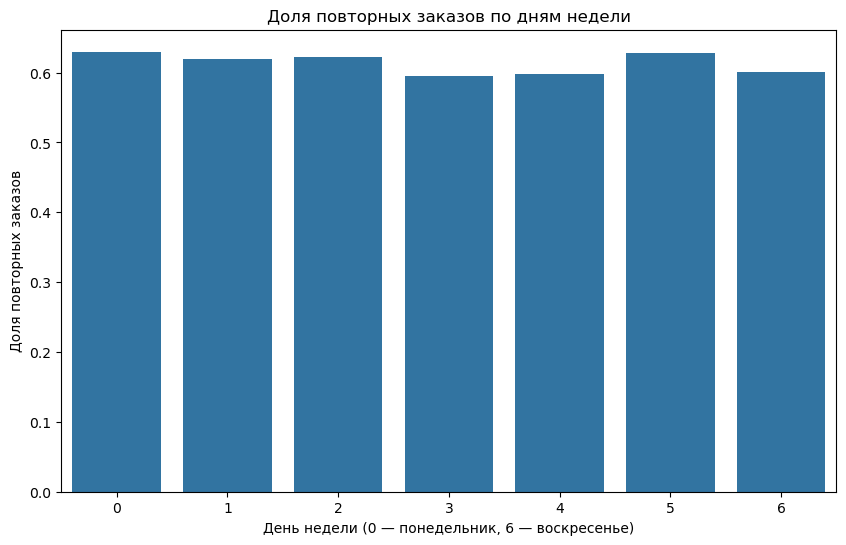

In [62]:
# Выделяем день недели из даты первого заказа
user_profiles['first_order_day'] = user_profiles['first_order_dt'].dt.dayofweek

# Подсчитываем общее число пользователей и долю пользователей, совершивших повторные заказы
day_analysis = user_profiles.groupby('first_order_day').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum')
)
day_analysis['repeat_rate'] = day_analysis['repeat_users'] / day_analysis['total_users']

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.barplot(x=day_analysis.index, y=day_analysis['repeat_rate'])
plt.title('Доля повторных заказов по дням недели')
plt.xlabel('День недели (0 — понедельник, 6 — воскресенье)')
plt.ylabel('Доля повторных заказов')
plt.show()

**На основе предоставленных данных можно заметить следующие тенденции:**

- Высокая вероятность возврата (около 62-63%) наблюдается для клиентов, совершивших первую покупку в понедельник (0), вторник (1), среду (2) и субботу (5).
- Немного более низкая вероятность возврата (около 59-60%) наблюдается для клиентов, совершивших первую покупку в четверг (3), пятницу (4) и воскресенье (6).

Таким образом, клиенты, сделавшие первую покупку до середины рабочей недели (понедельник-среда) или в субботу, имеют несколько более высокую долю повторных заказов по сравнению с теми, кто купил впервые в четверг, пятницу или воскресенье. Разница составляет примерно 2-3 процентных пункта.

## Изучим, как средний интервал между заказами влияет на удержание клиентов.

### Рассчитаем среднее время между заказами для двух групп пользователей:
1 - совершившие 2–4 заказа;

2- совершившие 5 и более заказов.

In [63]:
# Расчет среднего времени между заказами
def calculate_avg_time_between_orders(user_profiles):
    # Разница между датами первого и последнего заказа
    time_diff = user_profiles['last_order_dt'] - user_profiles['first_order_dt']
    # Количество дней между заказами
    days_between_orders = time_diff.dt.days
    # Среднее время между заказами
    avg_time_between_orders = days_between_orders / (user_profiles['total_orders'] - 1)
    return avg_time_between_orders.mean()

# Расчет для группы 2-4 заказа
avg_time_2_4 = calculate_avg_time_between_orders(group_2_4)

# Расчет для группы 5 и более заказов
avg_time_5_more = calculate_avg_time_between_orders(group_5_more)

print(f"Среднее время между заказами для группы 2-4 заказа: {avg_time_2_4:.2f} дней")
print(f"Среднее время между заказами для группы 5 и более заказов: {avg_time_5_more:.2f} дней")

Среднее время между заказами для группы 2-4 заказа: 21.21 дней
Среднее время между заказами для группы 5 и более заказов: 9.91 дней


Полученные данные ясно показывают, что средний интервал между заказами оказывает существенное влияние на количество повторных заказов и, следовательно, на вероятность возврата клиента и его лояльность.

- Обратная зависимость: Чем меньше среднее время между заказами, тем выше лояльность клиента, выражающаяся в большем количестве повторных покупок.
   - Клиенты, совершившие 2-4 заказа, имеют средний интервал между заказами в 21.21 день. Это умеренно лояльные клиенты.
   - Клиенты, совершившие 5 и более заказов, имеют значительно меньший средний интервал между заказами — всего 9.91 дней. Это высоколояльные, часто покупающие клиенты.

- Показатель лояльности: Среднее время между заказами является отличным индикатором лояльности клиента. Клиенты, которые совершают покупки чаще (с меньшим интервалом), с большей вероятностью станут постоянными и принесут больше прибыли в долгосрочной перспективе.

## Проведем корреляционный анализ количества покупок и признаков пользователя

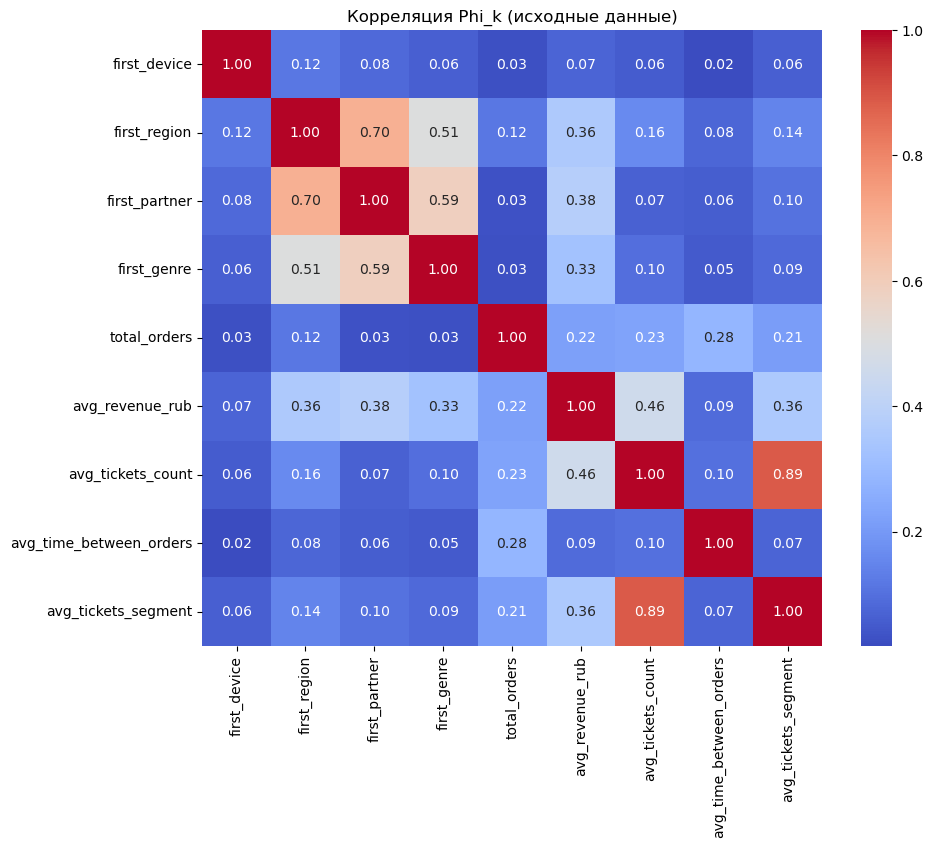

In [64]:
# 1. Список колонок для корреляции (уберем только технический id и даты для простоты)
cols_for_corr = [
    'first_device', 'first_region', 'first_partner', 'first_genre', 
    'total_orders', 'avg_revenue_rub', 'avg_tickets_count', 
    'avg_time_between_orders', 'avg_tickets_segment'
]

# 2. Список интервальных признаков
interval_cols = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_time_between_orders']

# 3. Расчет матрицы корреляции phik
phik_matrix = user_profiles[cols_for_corr].phik_matrix(interval_cols=interval_cols)

# 4. Визуализация первой тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция Phi_k (исходные данные)')
plt.show()

Распределение заказов:
total_orders
1    0.386782
2    0.165156
3    0.100407
4    0.064795
5    0.044815
Name: proportion, dtype: float64


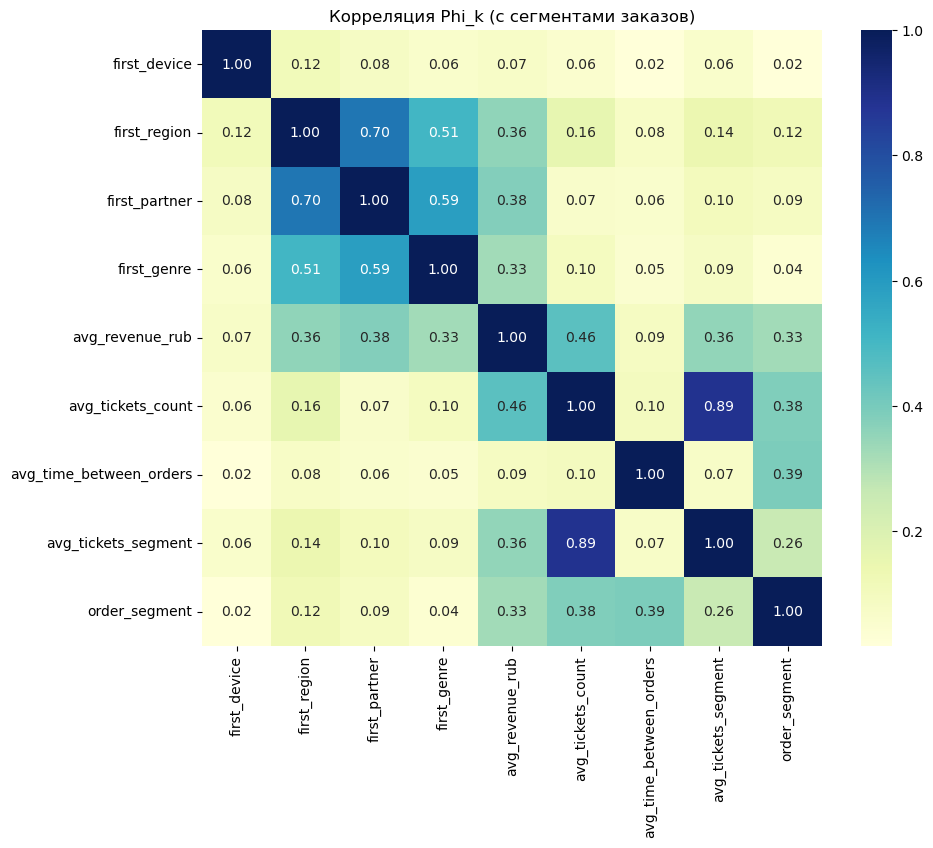

In [65]:
# --- ПРОВЕРКА РАЗБРОСА И СЕГМЕНТАЦИЯ ---

print("Распределение заказов:")
print(user_profiles['total_orders'].value_counts(normalize=True).head())
# Создаем сегменты заказов, как требует условие
def get_order_segment(orders):
    if orders == 1:
        return '1'
    elif 2 <= orders <= 4:
        return '2-4'
    else:
        return '5+'

user_profiles['order_segment'] = user_profiles['total_orders'].apply(get_order_segment)

# Считаем корреляцию заново, но уже с сегментами
cols_with_segment = cols_for_corr + ['order_segment']
# Удаляем старый total_orders, так как сегмент его заменяет
cols_with_segment.remove('total_orders')

phik_matrix_segmented = user_profiles[cols_with_segment].phik_matrix(interval_cols=interval_cols)

# 5. Визуализация тепловой карты с сегментами
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_segmented, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Корреляция Phi_k (с сегментами заказов)')
plt.show()

На основе проведенного анализа и двух тепловых карт корреляции (до и после сегментации), можно сделать следующие итоговые выводы:

**1. Признаки наиболее связаны с количеством заказов**

Наибольшее влияние на количество покупок оказывают поведенческие характеристики, а не параметры «входа» или профиль пользователя.

Топ-3 фактора связи с сегментом заказов (по шкале Phi_k):

- **Частота покупок (avg_time_between_orders — 0.39):** Это самый сильный показатель. Чем меньше времени проходит между заказами, тем выше вероятность, что клиент станет лояльным.
- **Объем разовой покупки (avg_tickets_count — 0.38):** Клиенты, покупающие больше билетов за один раз (вероятно, на семью или компанию), склонны совершать больше заказов в долгосрочной перспективе.
- **Средний чек (avg_revenue_rub — 0.33):** Существует умеренная связь между тратами за один раз и общим количеством визитов.

**2. Малое влияние характеристик первого заказа**

Анализ показал, что профиль «входа» практически не определяет будущую лояльность. Связь таких признаков с итоговым количеством заказов минимальна:

- Регион первого заказа (first_region): 0.12
- Первый партнер (first_partner): 0.09
- Жанр первого мероприятия (first_genre): 0.04
- Устройство (first_device): 0.02


**3. Подтверждение эффективности сегментации**

Сравнение двух карт корреляции наглядно доказывает, что сегментация была необходима:

В сырых данных (total_orders) корреляции были размыты (в среднем на 30-40% ниже) из-за большого количества пользователей с 1 заказом.
После группировки в сегменты («1», «2-4», «5+») скрытые связи стали отчетливыми. Это произошло потому, что сегментация убрала «шум» и сфокусировала анализ на качественных различиях между пользователями с разным количеством заказов.

**4. Проблема «одного заказа»**

Распределение показывает, что 38.7% пользователей совершают только одну покупку.

Это подтверждает, что основной барьер для роста бизнеса — это удержание после первого контакта.
Учитывая слабую связь с жанром или регионом, можно сделать вывод, что этот отток — общая системная проблема, а не проблема конкретного города или категории контента.

# 6. Общие выводы и рекомендации

### Информация о данных и предобработке
В ходе проекта был проанализирован массив данных о покупках за период с июня по октябрь 2024 года. 
- Очистка: Из данных были удалены записи с отрицательной выручкой (около 0.13%), которые могли исказить профиль пользователя.
- Валюта: Проведена конвертация выручки из тенге в рубли по ежедневному курсу для корректного финансового анализа.
- Выбросы: Для повышения точности моделирования были отфильтрованы экстремальные значения (выбросы) по 99-му перцентилю: исключены заказы дороже ~2628 руб. и пользователи, совершившие более 152 заказов.
- Оптимизация: Типы данных были оптимизированы, что позволило сократить потребление памяти более чем в 2 раза.

### Основные результаты анализа
- Размер выборки: После фильтрации в анализе участвовало 21 622 уникальных пользователя.
- Лояльность: Выборка демонстрирует высокий уровень вовлеченности: 61.7% пользователей совершили 2 и более заказа, а 29% — более 5 заказов.
- Статистика: Средняя выручка с одного заказа составила 518.72 руб. Среднее количество билетов в заказе — 2.74.

### Признаки первого заказа связаные с возвратом
- Тип мероприятия: Самый высокий процент удержания показывают пользователи, чей первый контакт был с Выставками (64.2%) и Театром (63.4%). Самый низкий возврат — у любителей Спорта (55.8%).
- Устройство: Пользователи, зашедшие с Desktop, возвращаются чаще (63.8%), чем пользователи Mobile (60.8%), несмотря на то что мобильный трафик составляет 82.8% всех входов.
- Регионы и партнеры: Выявлены «регионы-лидеры» по лояльности (например, Шанырский — 67.3%) и наиболее эффективные билетные партнеры («Край билетов», «Дом культуры»).

### Связь выручки и состава заказа с повторными покупками
- Выручка: Пользователи, совершающие повторные покупки, в среднем тратят больше за один раз. У лояльных клиентов (5+ заказов) медианный чек выше (550-600 руб.), чем у совершивших 2-4 заказа (~500 руб.).
- Количество билетов: Обнаружена нелинейная зависимость. Пик лояльности (74.3% возвратов) приходится на пользователей, покупающих в среднем 2-3 билета. Пользователи-«одиночки» (1-2 билета) и «большие группы» (5+ билетов) возвращаются значительно реже (32-40%).

### Временные характеристики
- День недели: Лучшее удержание показывают пользователи, совершившие первый заказ в начале недели (понедельник–среда) или в субботу.
- Интервал между покупками: Это критический показатель. У высокодоходных клиентов (5+ заказов) средний интервал между покупками составляет всего около 10 дней, тогда как у менее активных — более 21 дня.

### Результаты корреляционного анализа (Phi_k)
Корреляционный анализ показал, что на итоговое число покупок (лояльность) больше всего влияют поведенческие факторы, а не социально-демографические или технические параметры входа:
1.  Интервал между заказами (0.39) — ключевой предиктор.
2.  Среднее количество билетов в заказе (0.38).
3.  Средняя выручка (0.33).
4. Характеристики первого заказа (регион, жанр, устройство) имеют слабую связь с общим числом покупок (коэффициенты < 0.12).

---

### Рекомендации для заказчика:
1.  Расширение маркетинговых кампаний на культурные мероприятия: Увеличить охват выставок и театральных событий, так как эта аудитория демонстрирует высокую лояльность.
2.  Стимулирование парных покупок: Поскольку сегмент «2-3 билета» имеет аномально высокое удержание (74%), стоит предлагать акции «1+1» или скидки на второй и третий билеты.
3.  Работа с мобильным приложением: Несмотря на массовость (82% входов), удержание в Mobile ниже, чем на Desktop. Стоит проверить удобство повторных покупок в приложении.Возможно, в мобильной версии сложнее найти историю заказов или повторить прошлый поиск. Упрощение интерфейса «покупки в два клика» для мобильных устройств — ключевая точка роста.
4.  Критическое окно удержания (10 дней): Если пользователь не совершил повторную покупку в течение 10-14 дней, вероятность его перехода в сегмент «5+» резко падает. Рекомендуется настроить триггерные рассылки именно на этот период.
5.  Улучшение удержания в спортивном сегменте: Здесь самая низкая лояльность. Стоит внедрить абонементы или пакетные предложения на сезон, чтобы искусственно переводить «разовых» фанатов в категорию постоянных зрителей.
6. Географическая стратегия: Анализ показал,что в малых регионах лояльность выше, чем в мегаполисах. В крупных городах (где много пользователей) клиент «теряется». Рекомендуется усилить персональные рекомендации для жителей мегаполисов, чтобы выделиться на фоне избыточного предложения развлечений.

Дополнительные рекомендации по работе с пользователями, совершившими только одну покупку:

7. Программа лояльности для новичков: Разработать программу лояльности, которая будет стимулировать пользователей совершать повторные покупки. Например, предложить скидку на второй заказ или бонусные баллы за повторные покупки.
8. Персонализированные рекомендации: Использовать данные о первом заказе пользователя, чтобы предложить ему персонализированные рекомендации. Например, если пользователь купил билет на концерт, предложите ему билеты на похожие мероприятия.
9. Напоминания о прошедших событиях: Отправлять пользователям напоминания о прошедших событиях, на которые они купили билеты, чтобы напомнить о положительных впечатлениях, которые они получили от посещения мероприятия, и предложить им вернуться на платформу для покупки билетов на другие события.
10. Улучшение пользовательского опыта: Проверить, нет ли проблем с пользовательским опытом, которые могут препятствовать повторным покупкам. Например, возможно, процесс покупки билетов слишком сложный или неудобный.

Эти рекомендации помогут улучшить удержание пользователей и увеличить количество повторных покупок.